In [263]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import preprocessing

pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

In [264]:
# We won't specify column names/types because the data is small enough that we don't hit issues.
# 'NA' is used both as a categorical value in several of the columns and to represent NaNs.  
# We'll need to sort this out when we engineer features.
train = pd.read_csv('data/house_train.csv')
test = pd.read_csv('data/house_test.csv')

In [265]:
train_trans = pd.DataFrame()
test_trans = pd.DataFrame()

In [266]:
# Categorical (Text) - Encode label -> categorical (integer)
# Categorical (Integer) - One hot!
# Continuous (Float/Integer) - DTB! Check for missing (bomb if missing...), convert to float (if necessary...), check distribution (bomb if skewed, etc...), transform (BoxCox) and scale (StandardScaler).

categorical_text = train.dtypes[train.dtypes == np.object].index.values
categorical_int = ['MSSubClass', 'OverallQual', 'OverallCond']

# These are actually integers but, because of the lack of NaN support in Pandas for integers, they got converted to floats.
# Not a problem because we'll convert everything to floats.
continuous_float = train.dtypes[train.dtypes == np.float].index.values

continuous_int_str = 'LotArea, YearBuilt, YearRemodAdd, BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, TotRmsAbvGrd, Fireplaces, GarageCars, GarageArea, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, MiscVal, MoSold, YrSold'
continuous_int = np.array(continuous_int_str.split(', '))
train[continuous_int] = train[continuous_int].astype(np.float)
test[continuous_int] = test[continuous_int].astype(np.float)

continuous = np.append(continuous_int, continuous_float, axis=0)

In [267]:
def plot_continuous(column_name, train_df=train, test_df=test):
  
  plt.figure(figsize=(20,5))

  sns.distplot(train_df[column_name].dropna(), label='Train')
  sns.distplot(test_df[column_name].dropna(), label='Test')

  plt.legend()
  plt.show()
  
  plt.figure(figsize=(20,5))

  plt.subplot(121)
  sns.boxplot(train_df[column_name])
  plt.subplot(122)
  sns.boxplot(test_df[column_name])
  
  plt.figure(figsize=(20,5))
  sns.regplot(train_df[column_name], train.SalePrice)
  plt.show()

  plt.show()

In [274]:
def process_continuous(column):
  
  train_outlier = (train[column] - train[column].mean()) > 3 * train[column].std()
  test_outlier = (test[column] - test[column].mean()) > 3 * test[column].std()

  has_outlier = np.any(train_outlier) | np.any(test_outlier)

  train_trans[column] = train[column]
  test_trans[column] = test[column]
  
  train_trans[column] = train_trans[column].fillna(train_trans[column].median())
  test_trans[column] = test_trans[column].fillna(test_trans[column].median())

  if has_outlier:
    train_trans.loc[train_outlier, column] = train_trans[column].median()
    test_trans.loc[test_outlier, column] = test_trans[column].median()
    
  is_skewed = (train_trans[column].skew() > 0.5) | (test_trans[column].skew() > 0.5)
    
  if (is_skewed):
    #train_trans[column] = np.log1p(train_trans[column])
    #test_trans[column] = np.log1p(test_trans[column])
    pass
    
  scaler = preprocessing.StandardScaler()
    
  train_trans[column] = scaler.fit_transform(train_trans[column].values.reshape(-1,1))    
  test_trans[column] = scaler.transform(test_trans[column].values.reshape(-1,1))

  plot_continuous(column, train_trans, test_trans)

LotArea


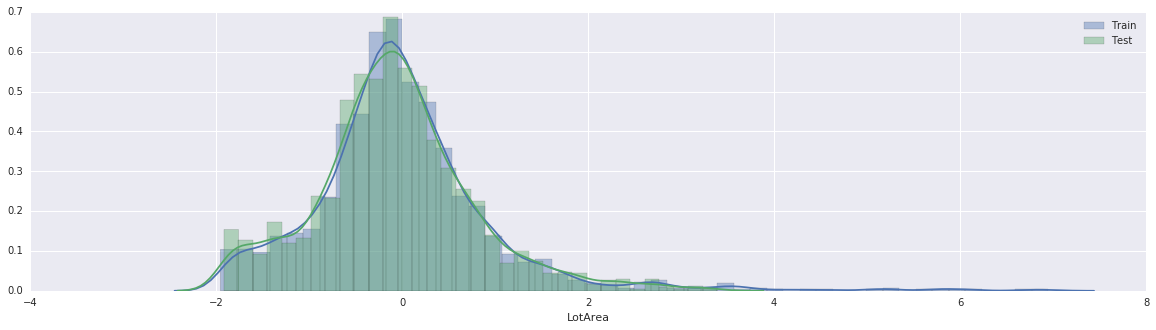

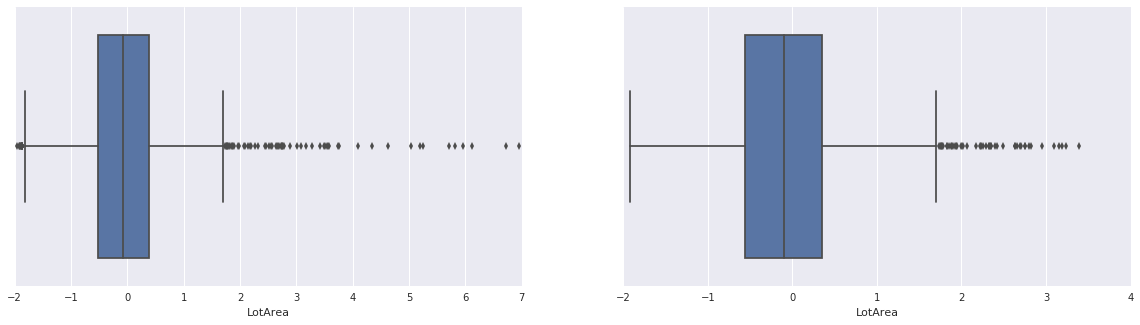

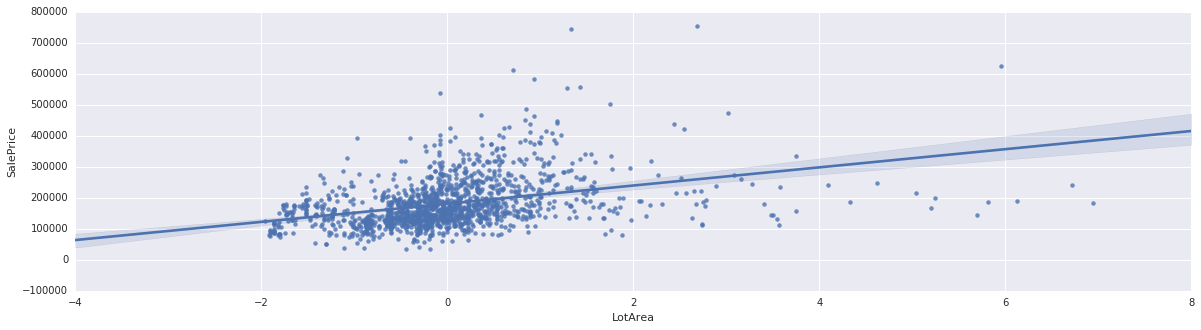

YearBuilt


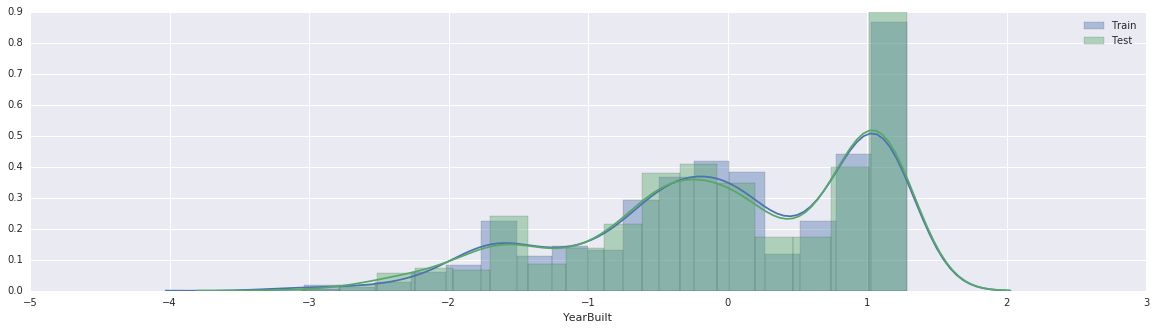

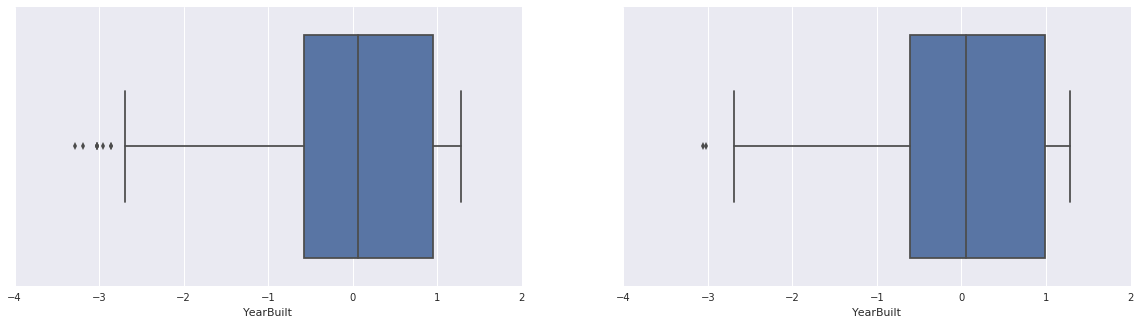

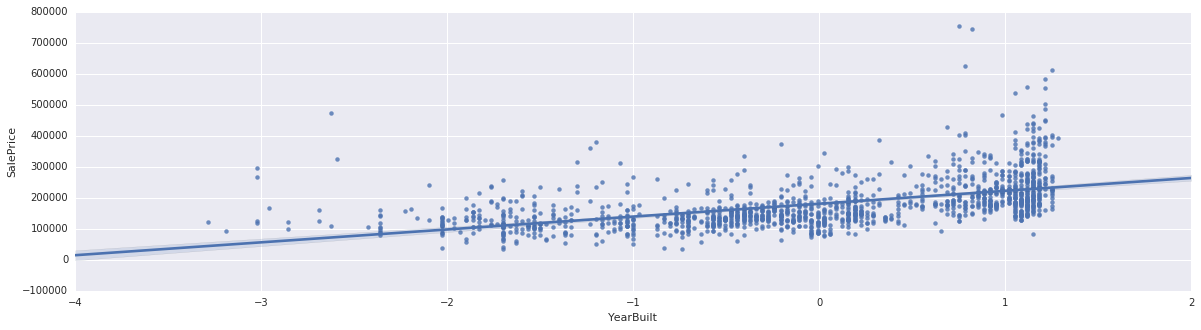

YearRemodAdd


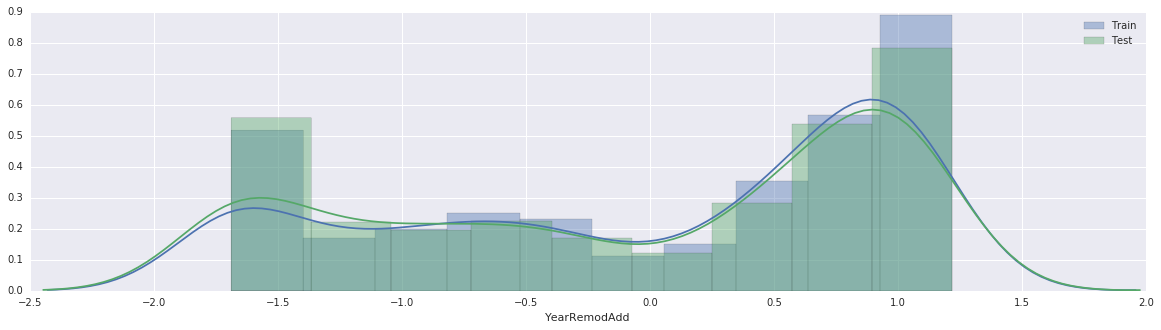

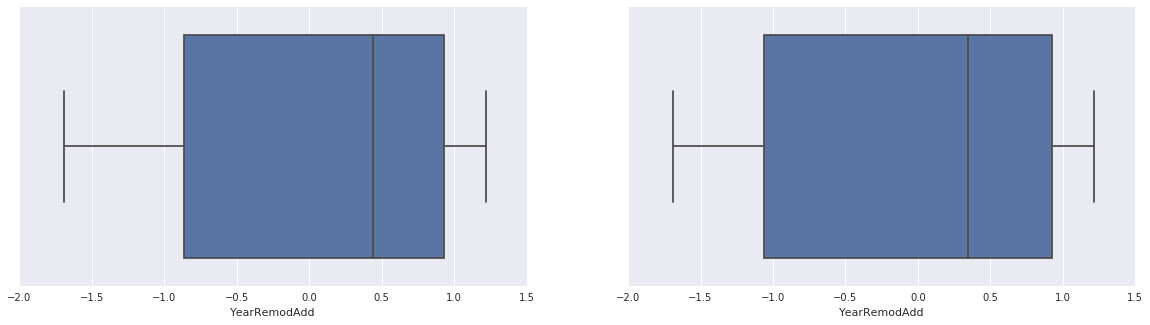

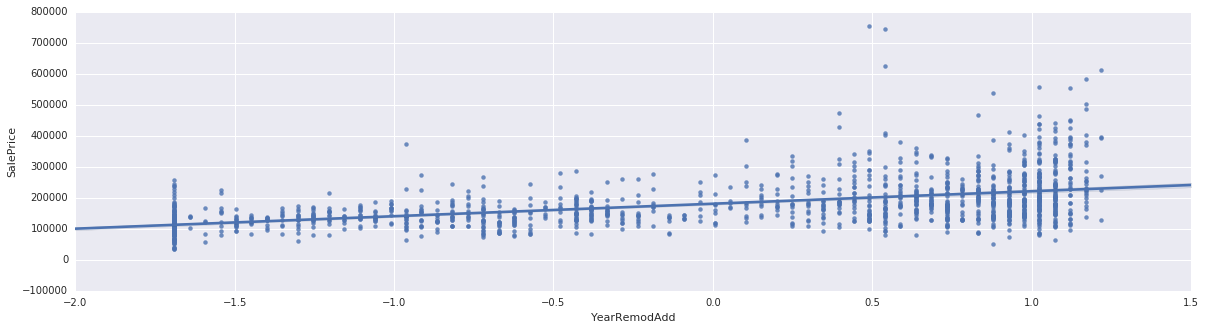

BsmtFinSF1


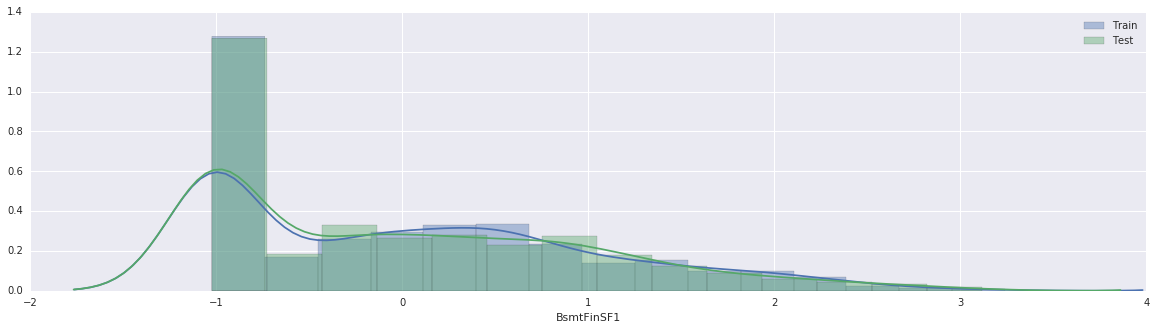

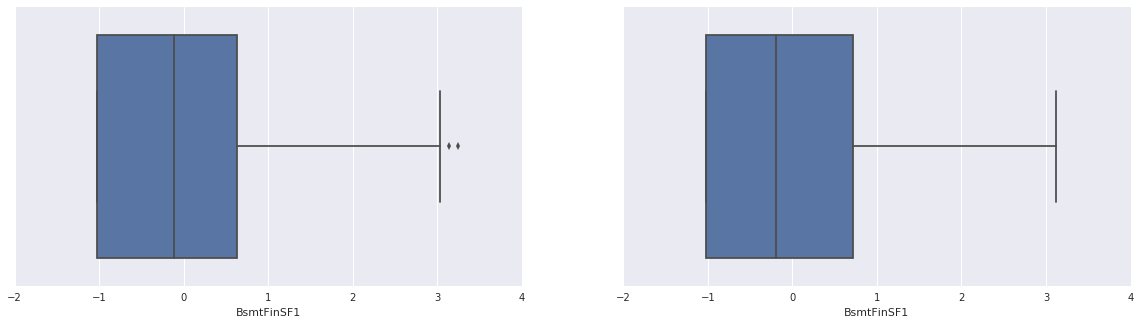

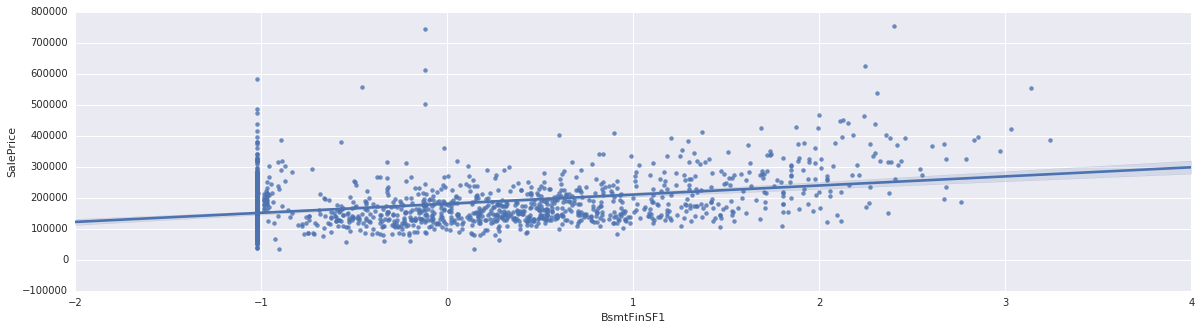

BsmtFinSF2


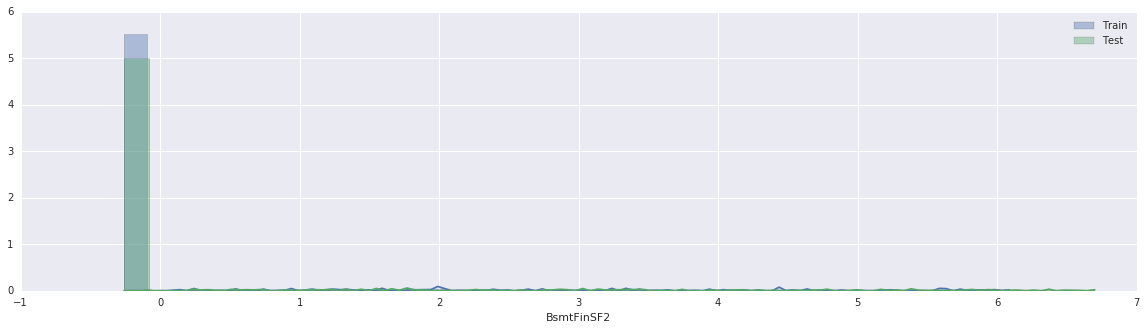

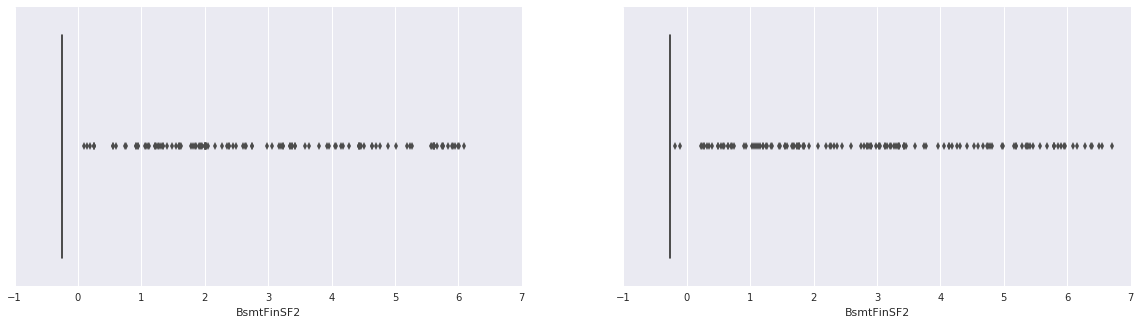

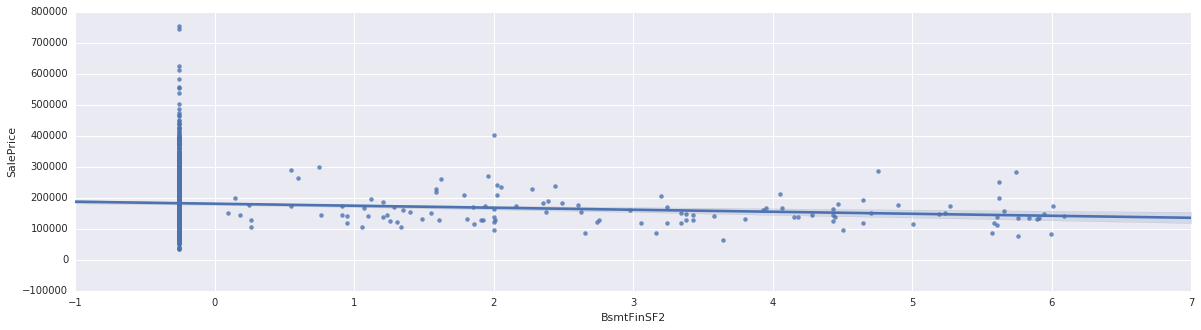

BsmtUnfSF


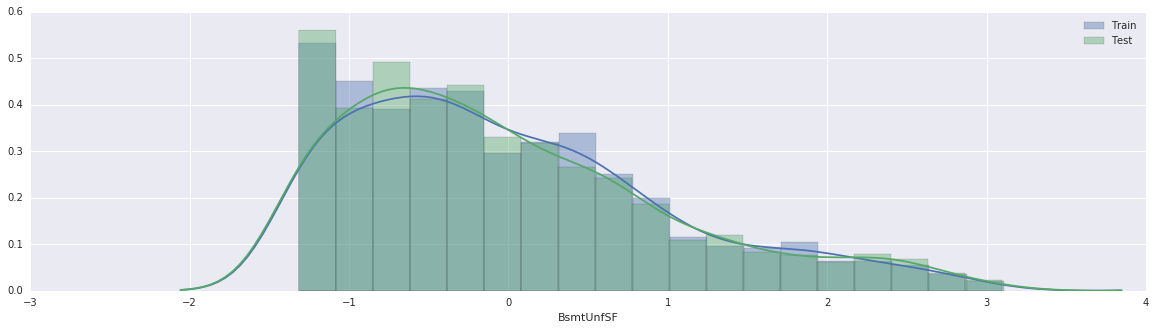

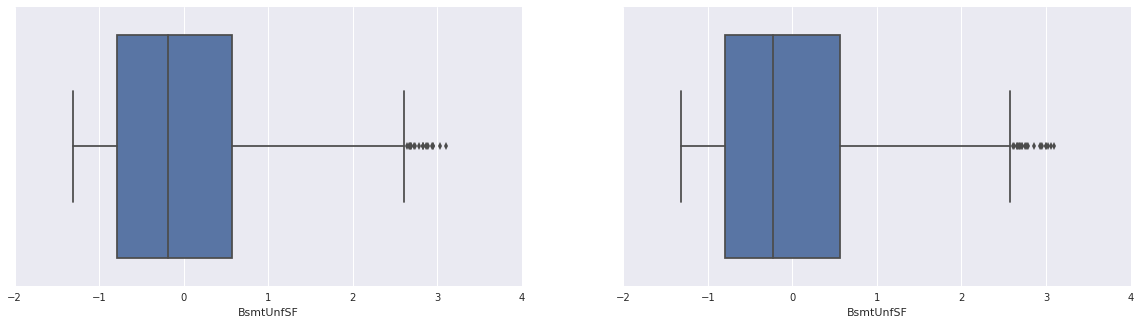

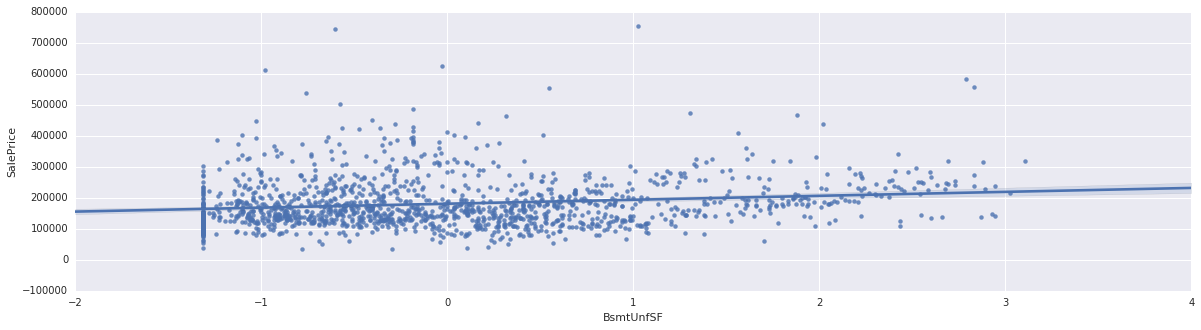

TotalBsmtSF


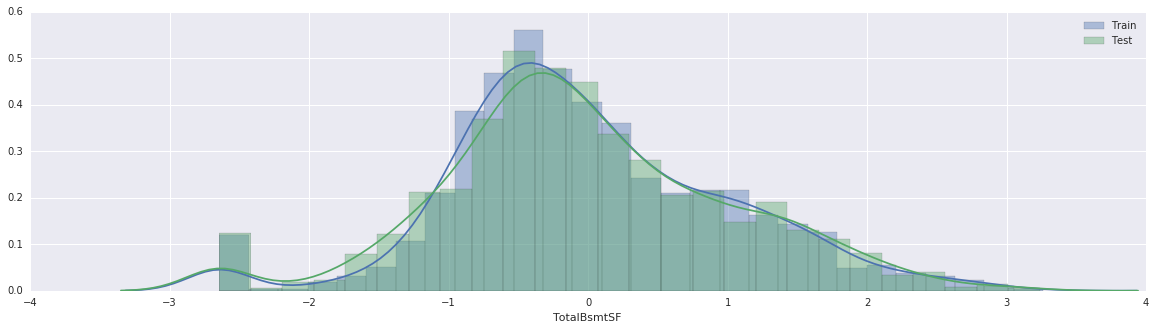

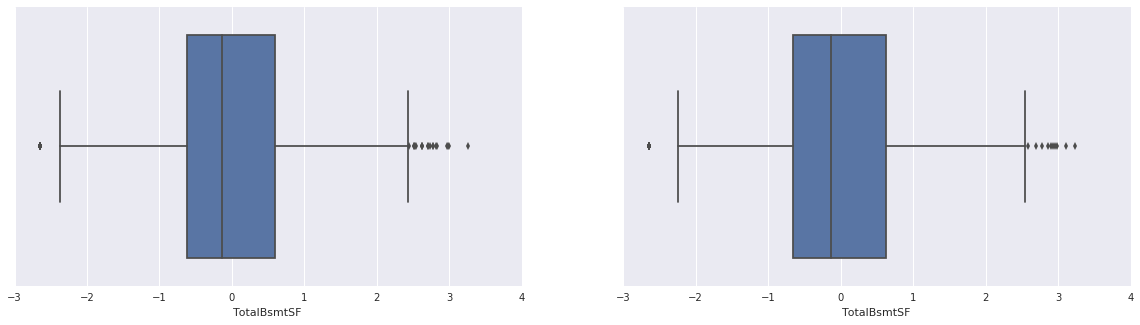

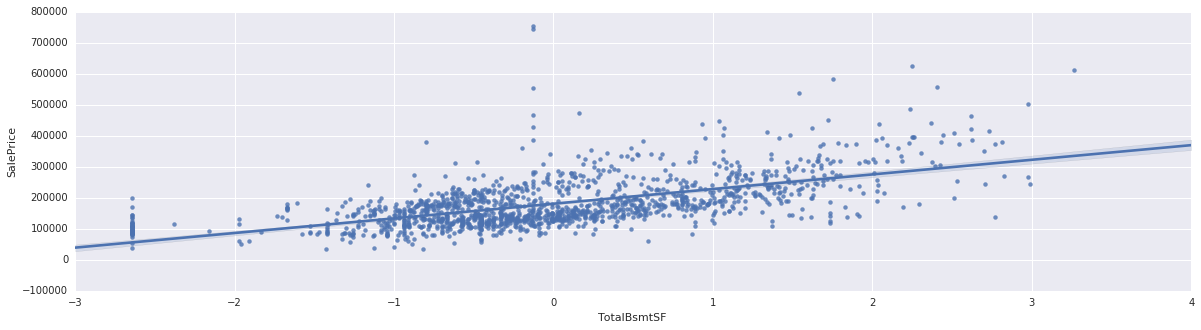

1stFlrSF


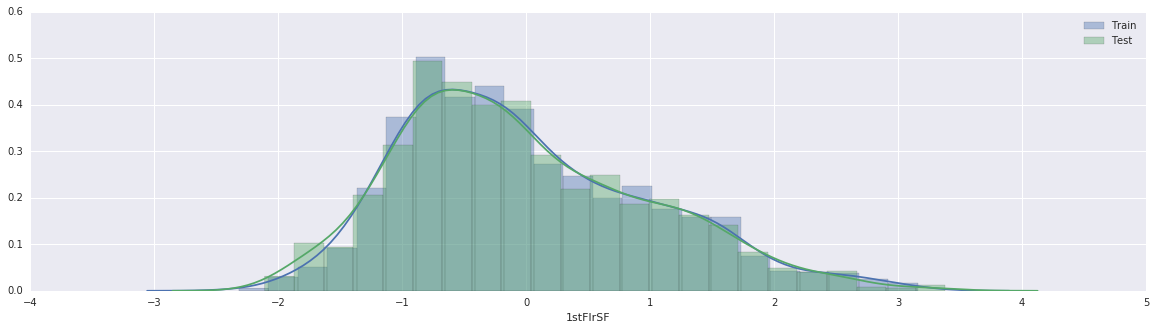

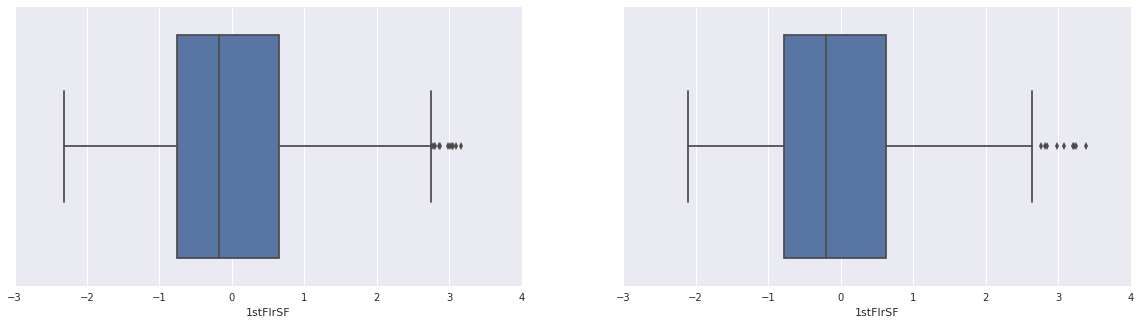

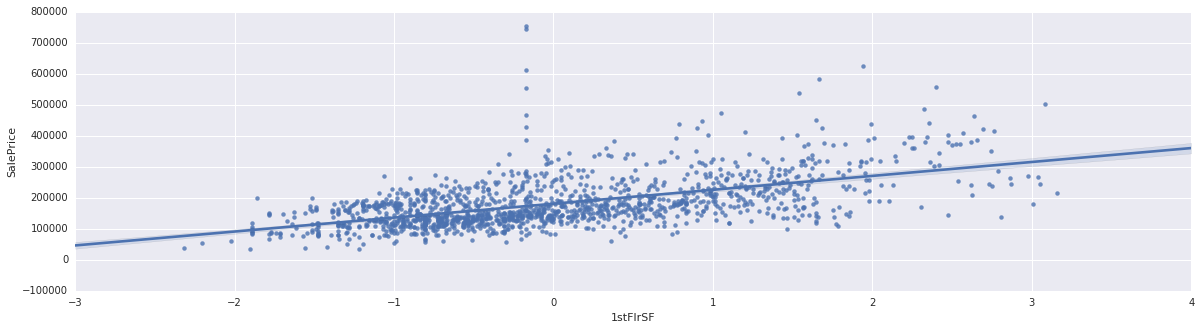

2ndFlrSF


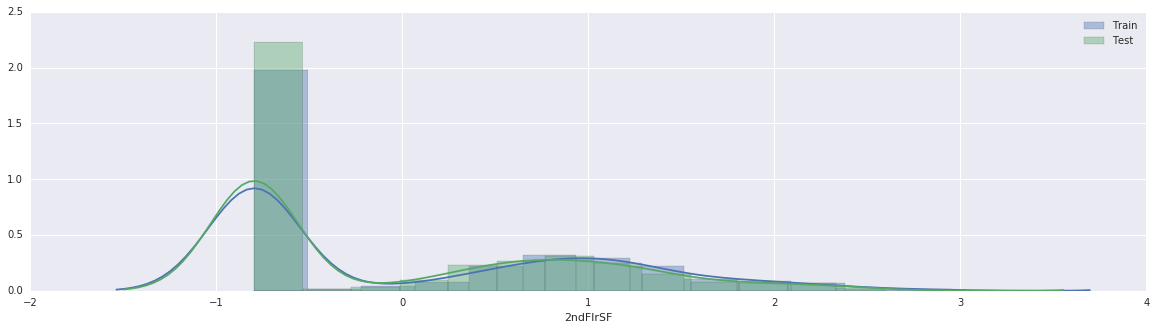

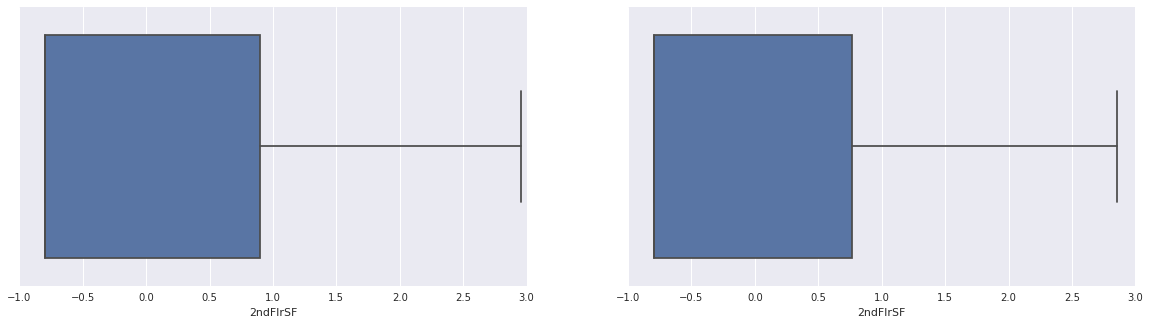

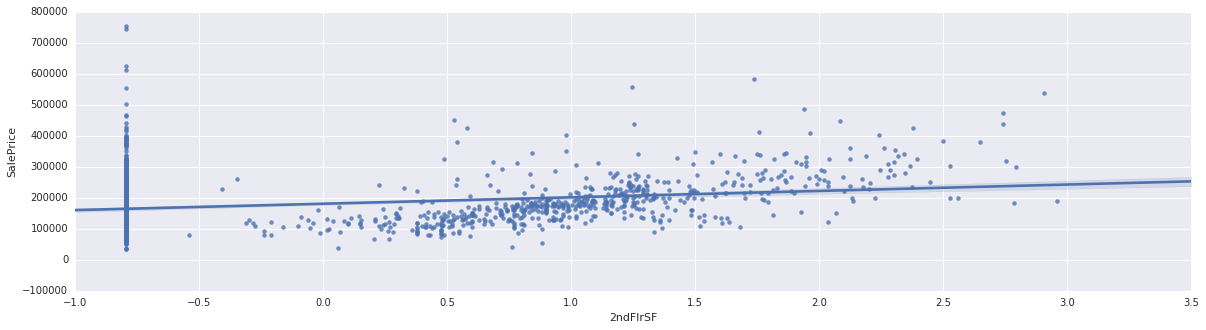

LowQualFinSF


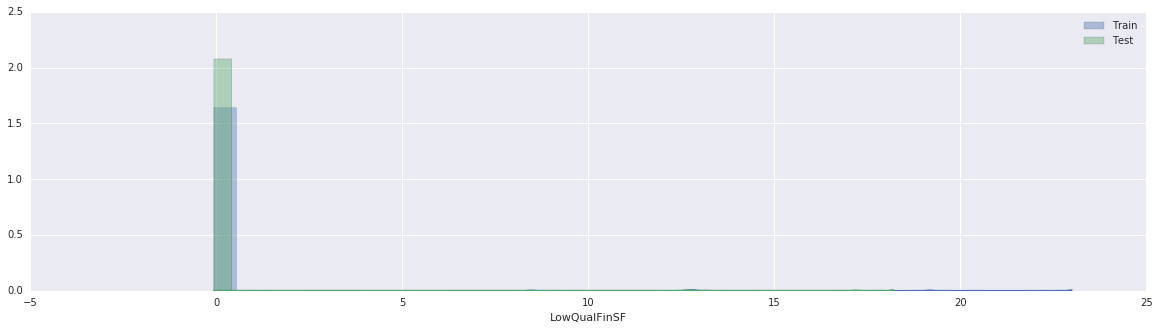

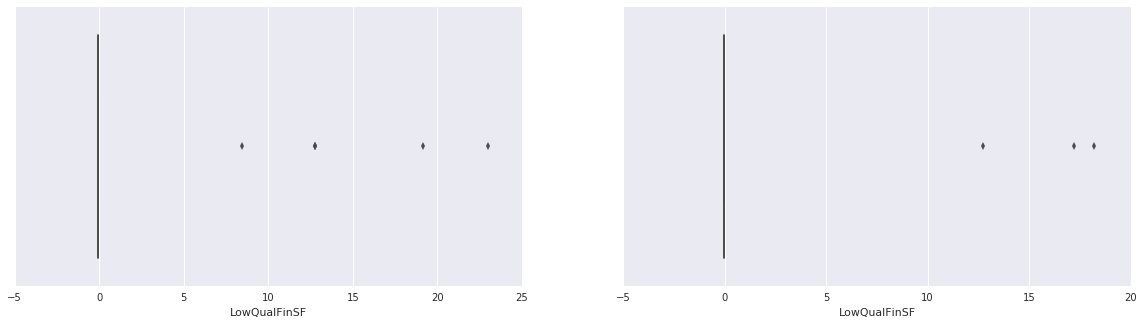

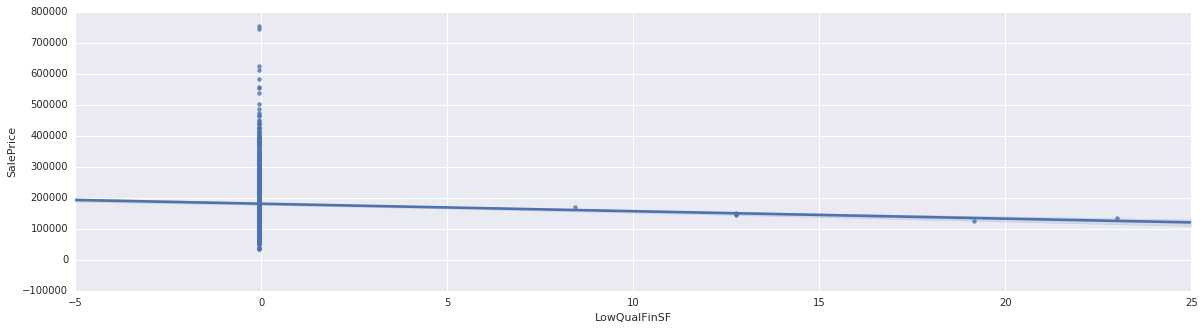

GrLivArea


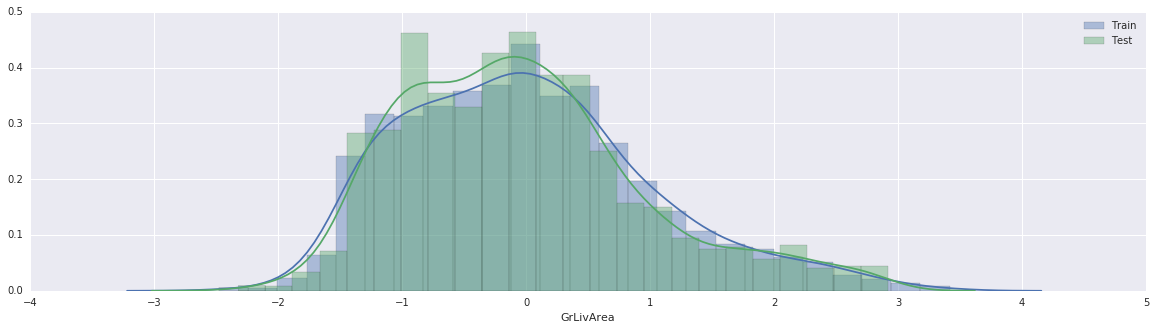

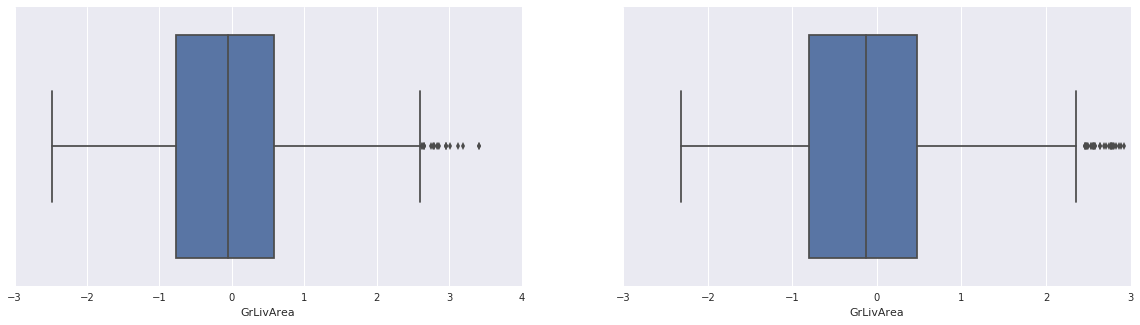

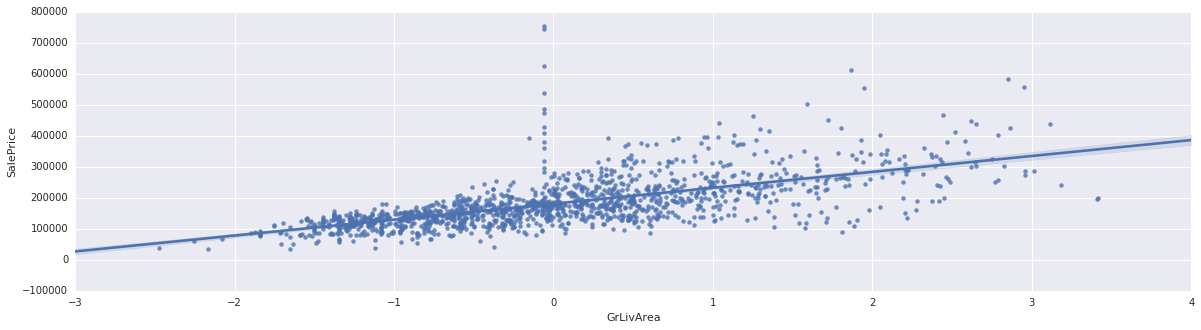

BsmtFullBath


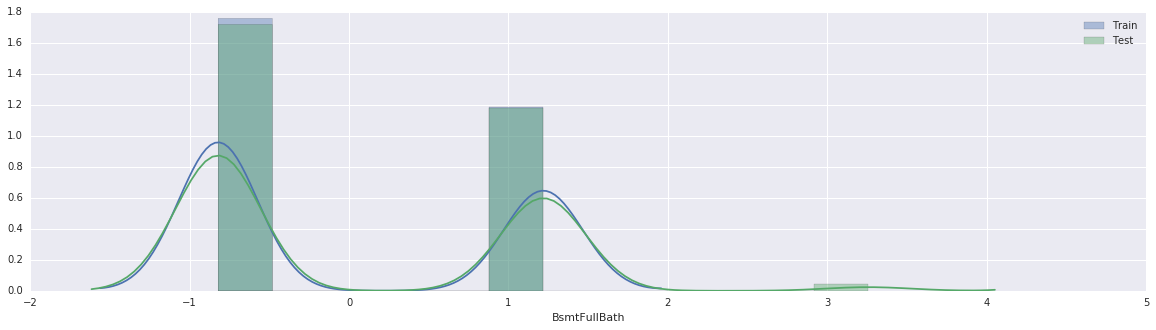

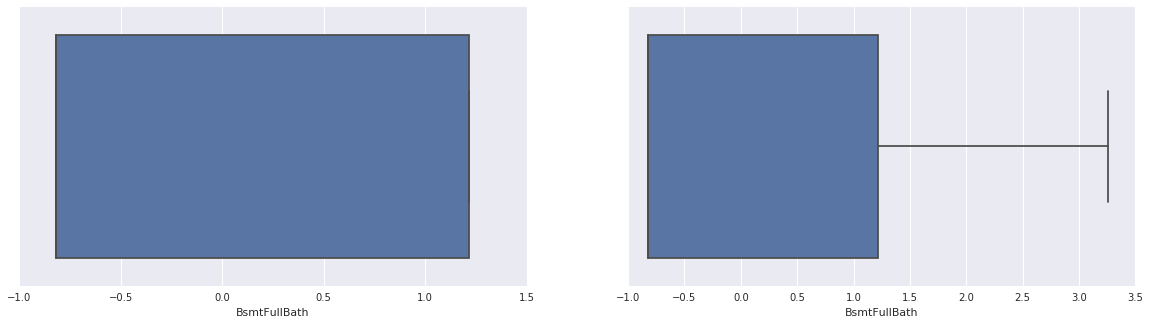

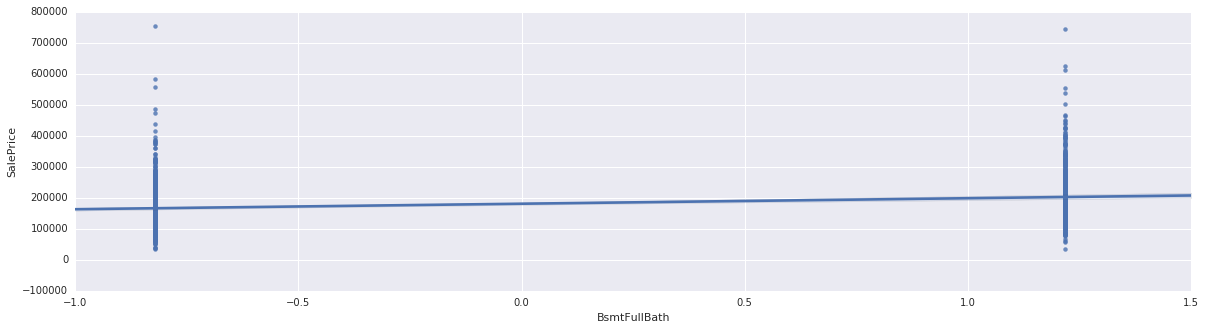

BsmtHalfBath


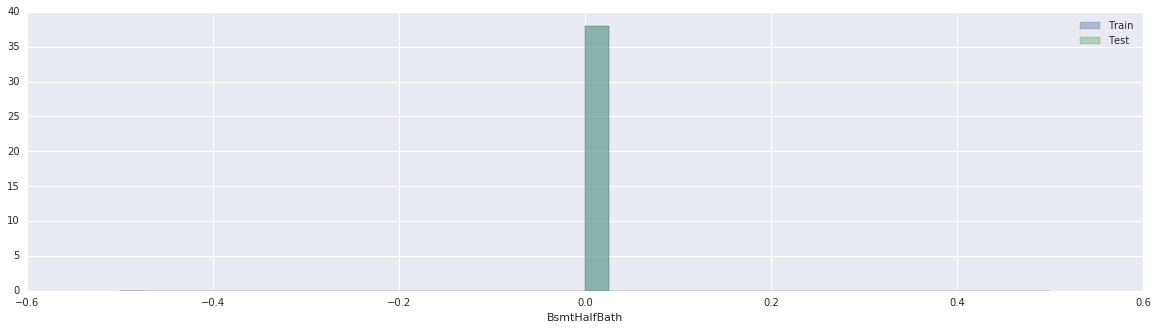

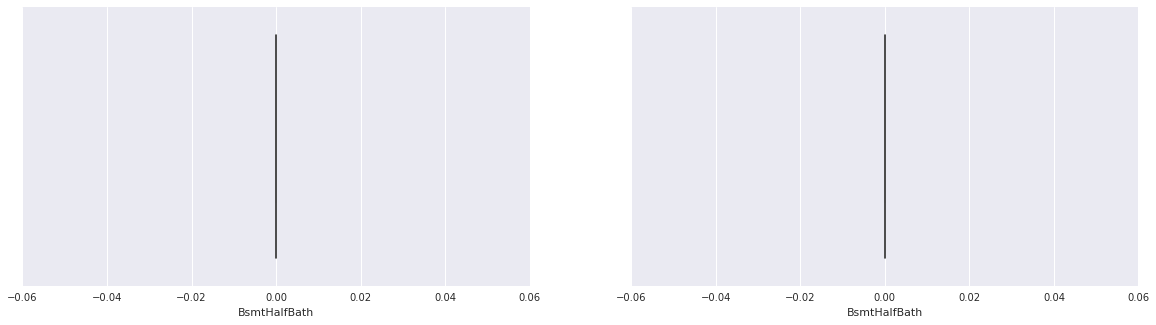

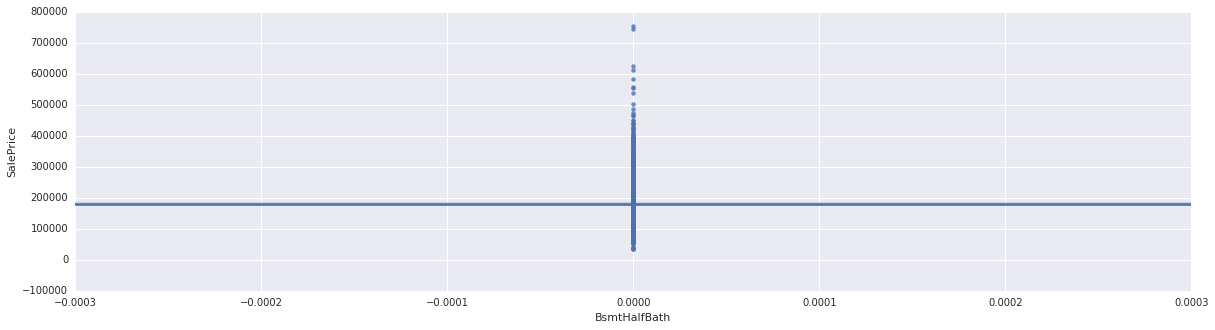

FullBath


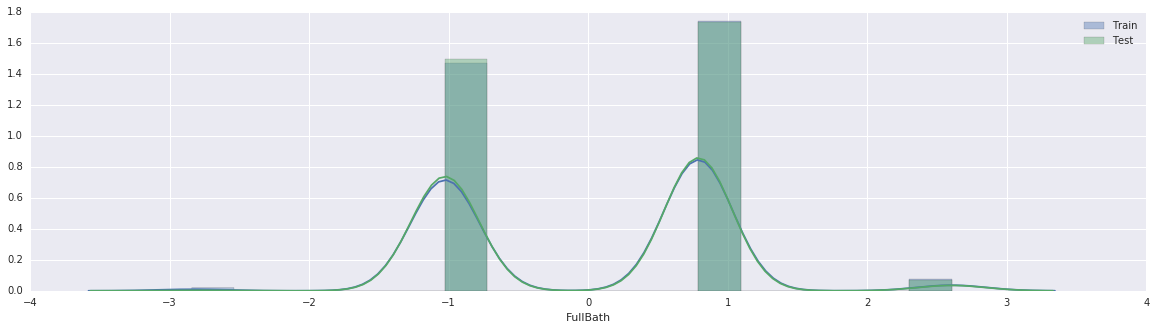

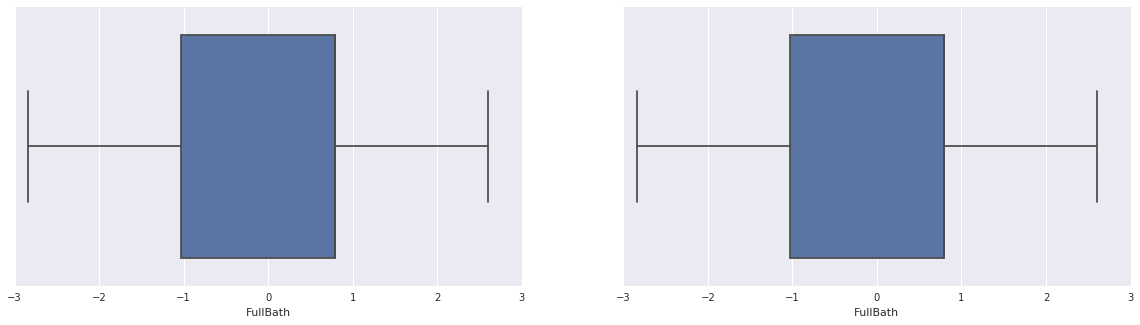

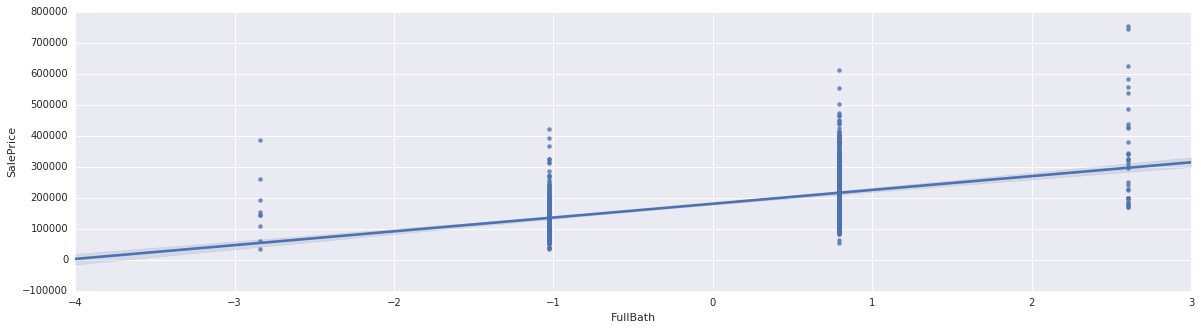

HalfBath


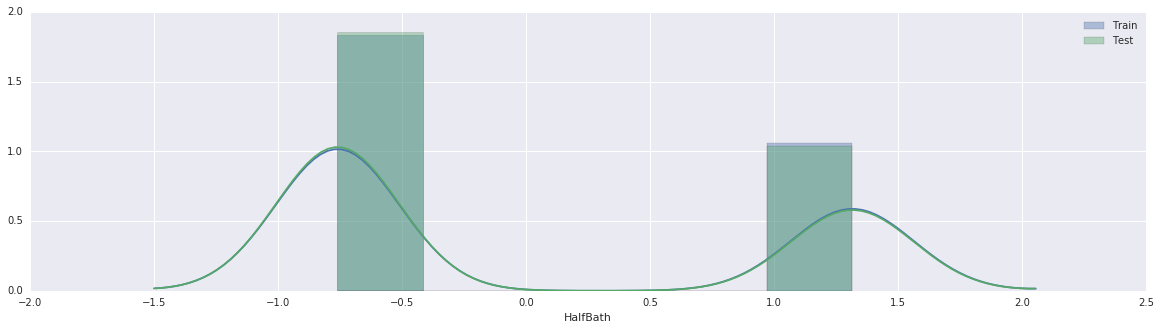

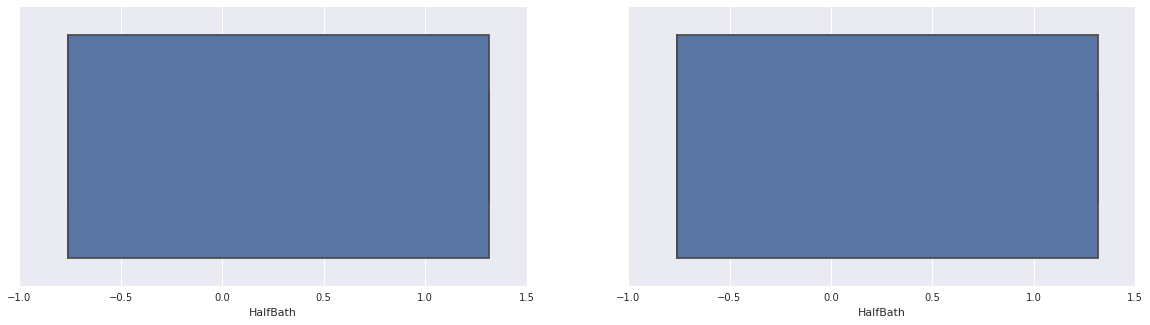

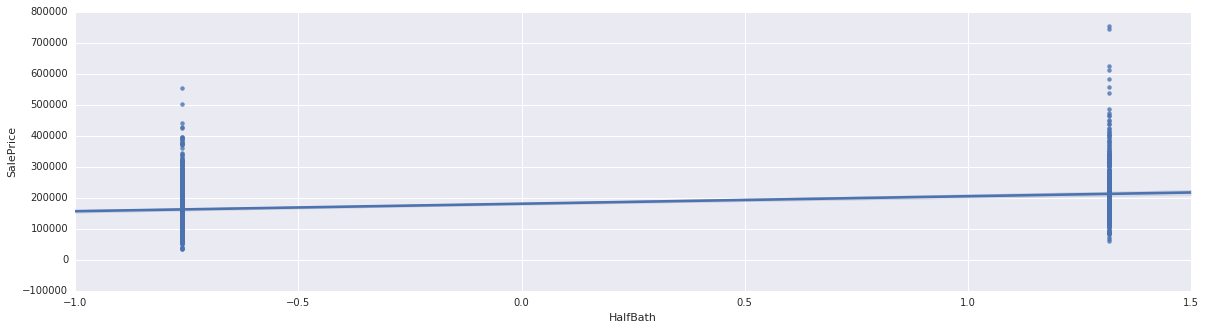

BedroomAbvGr


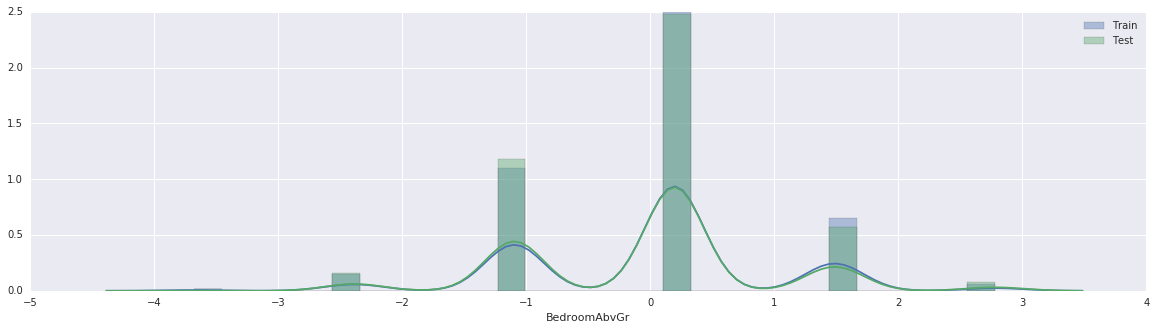

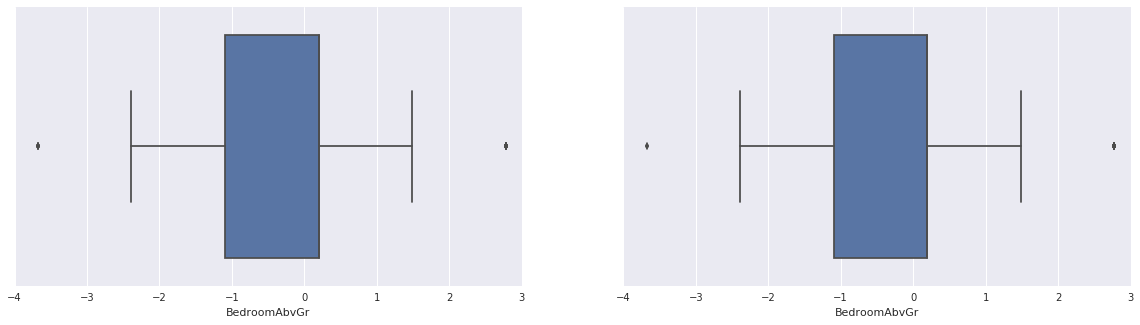

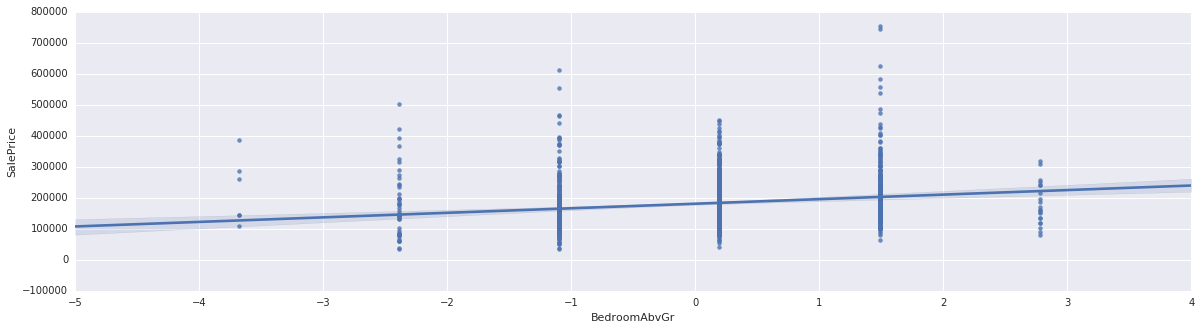

KitchenAbvGr


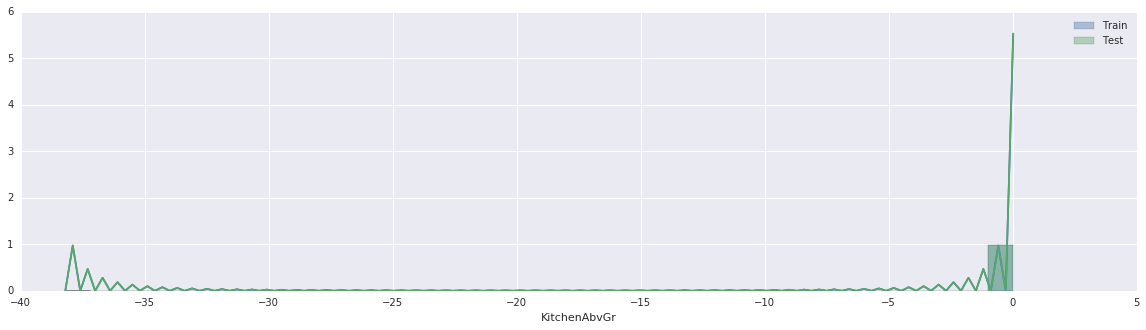

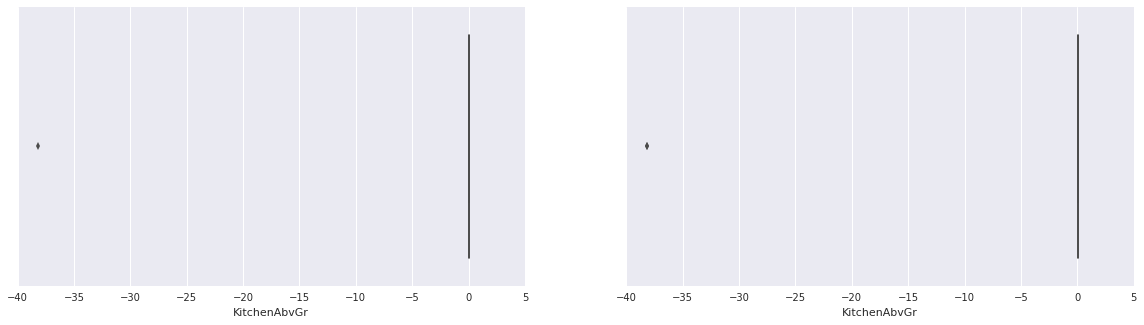

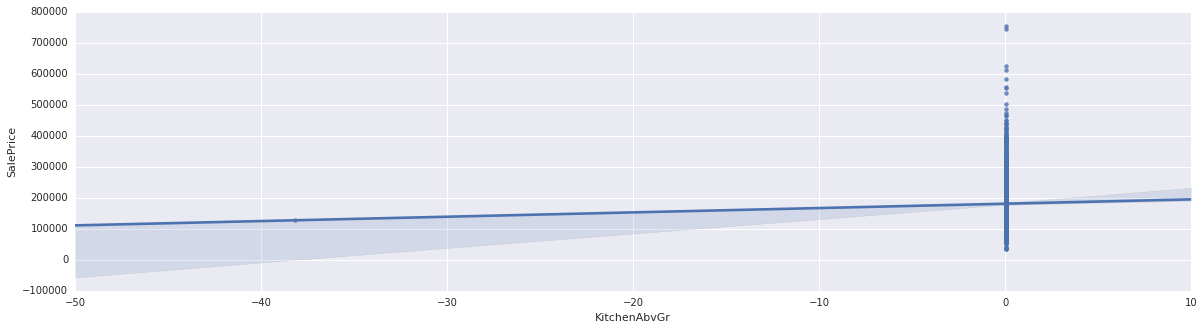

TotRmsAbvGrd


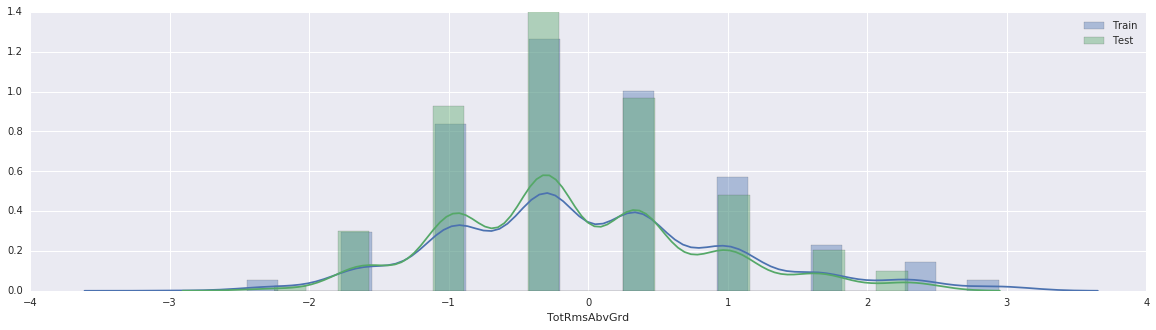

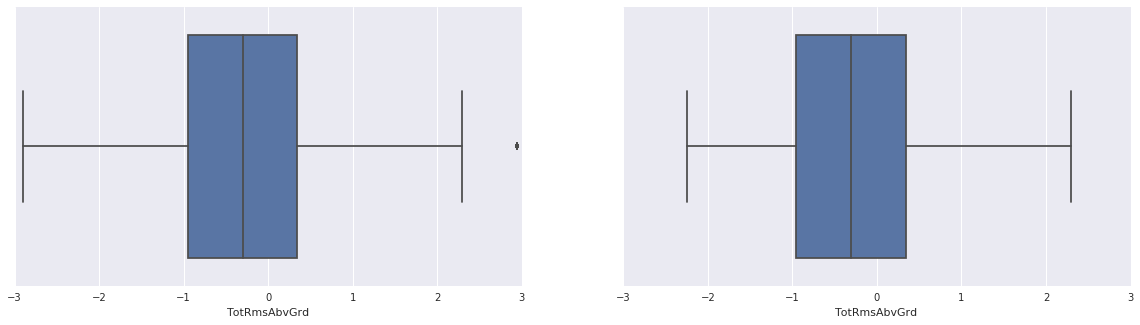

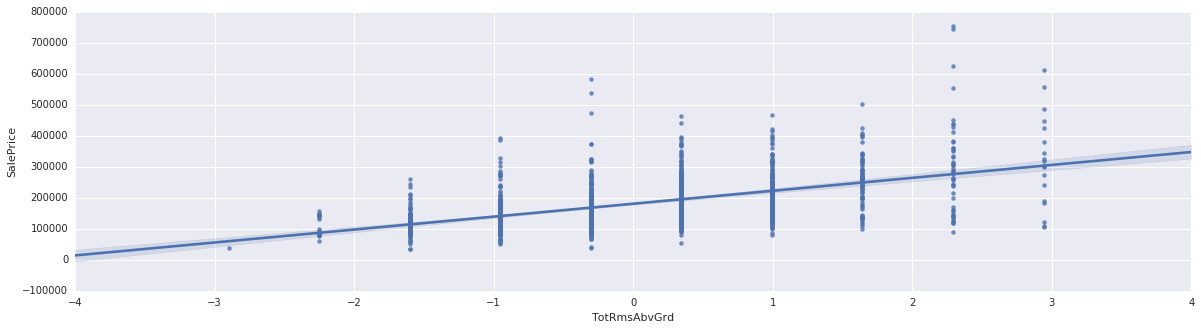

Fireplaces


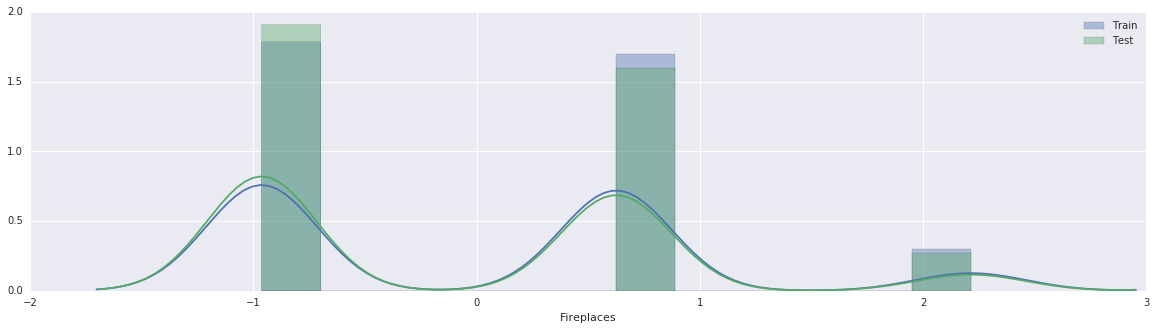

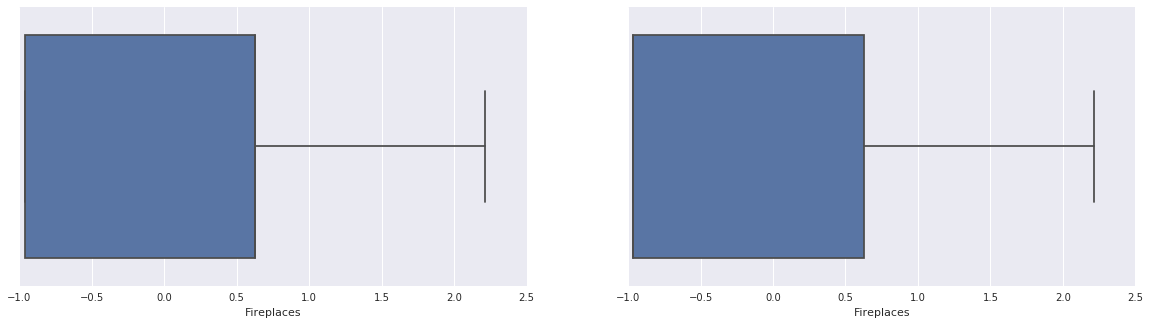

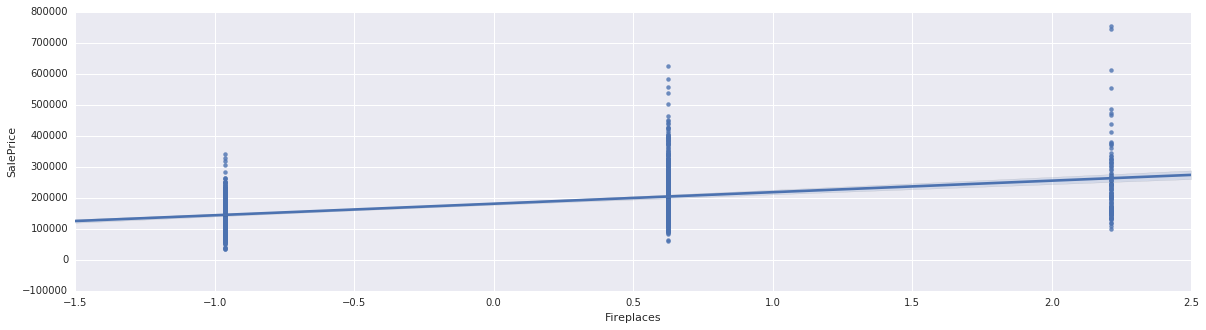

GarageCars


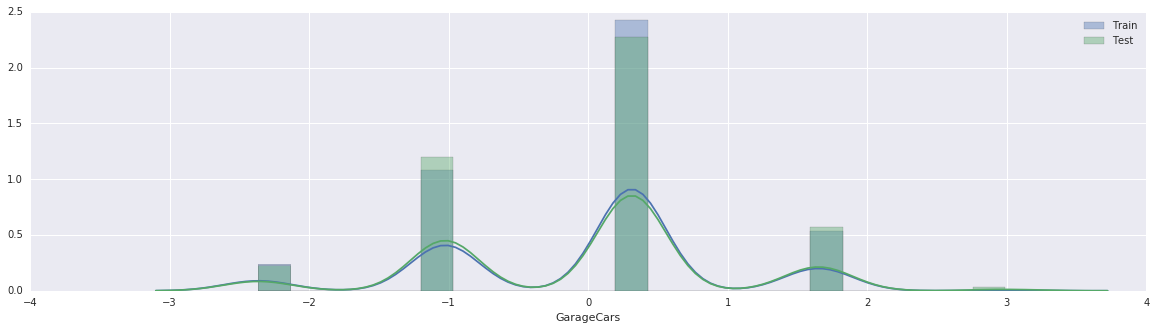

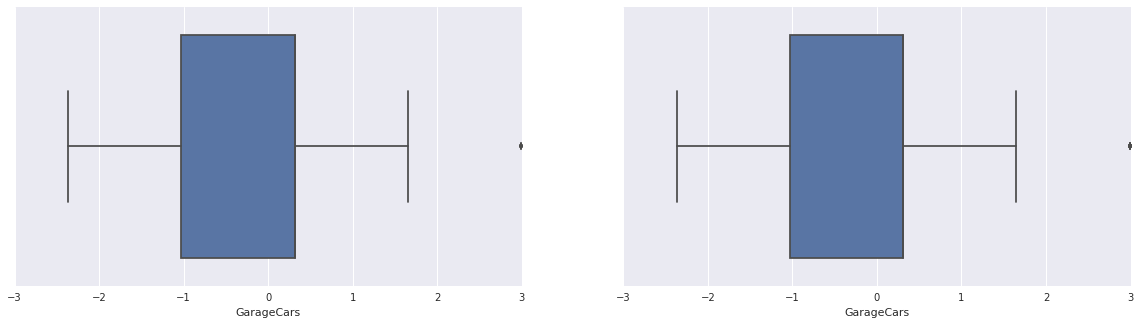

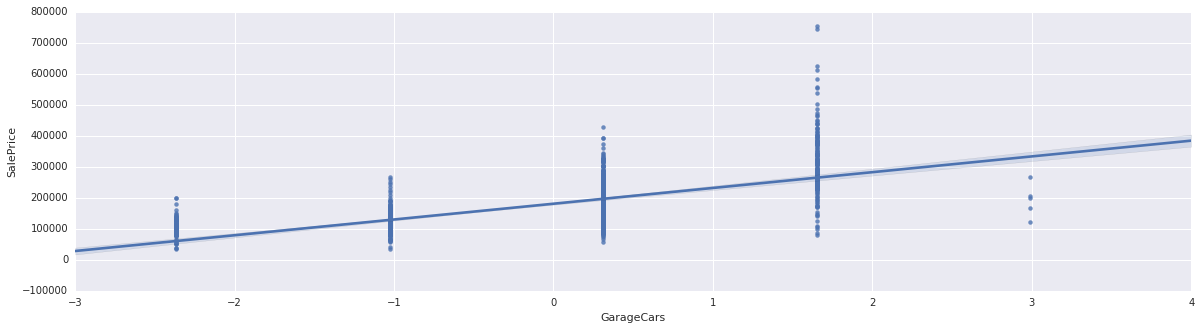

GarageArea


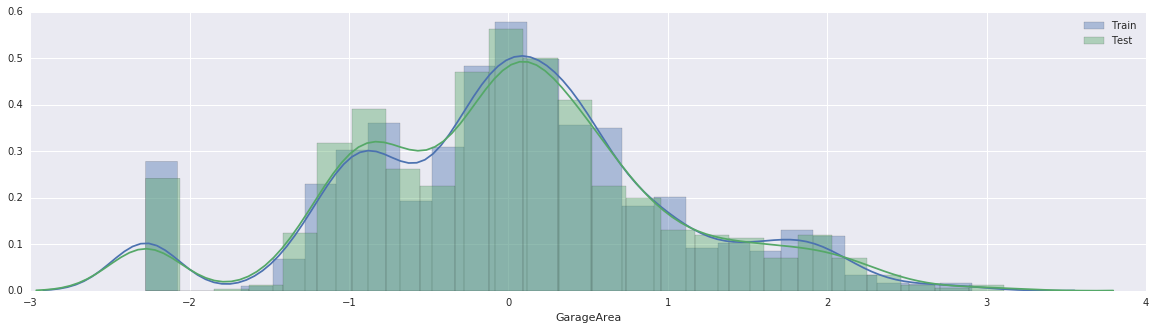

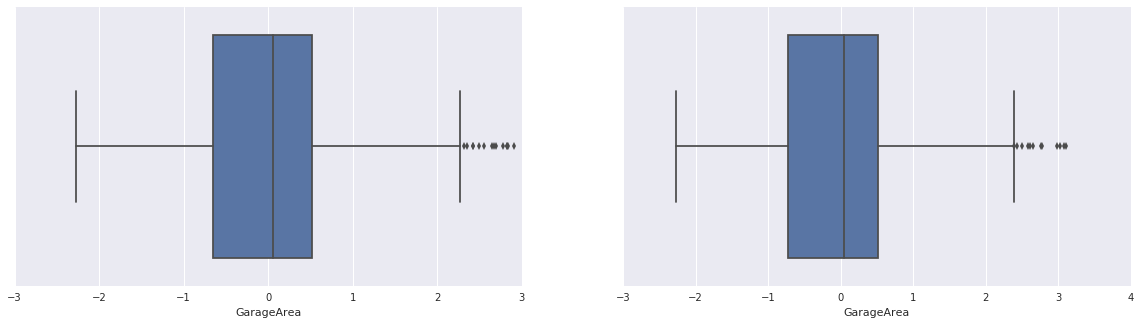

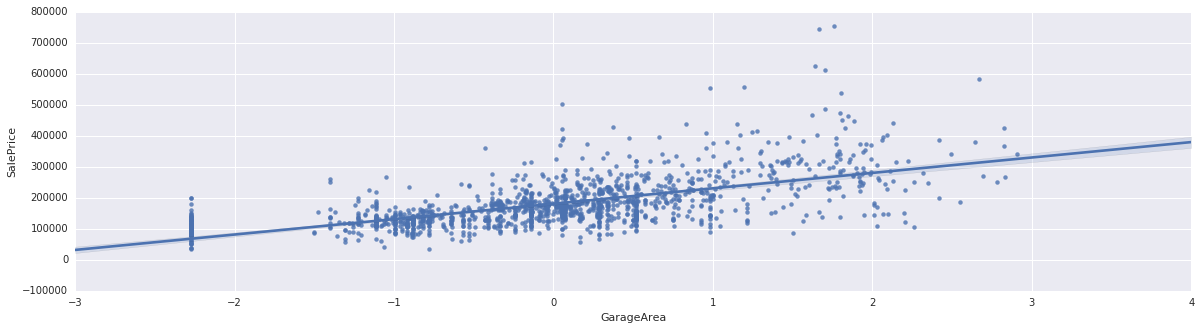

WoodDeckSF


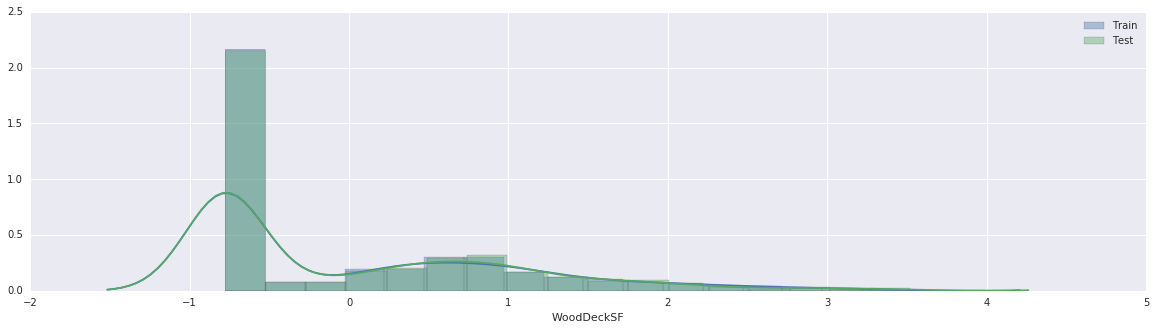

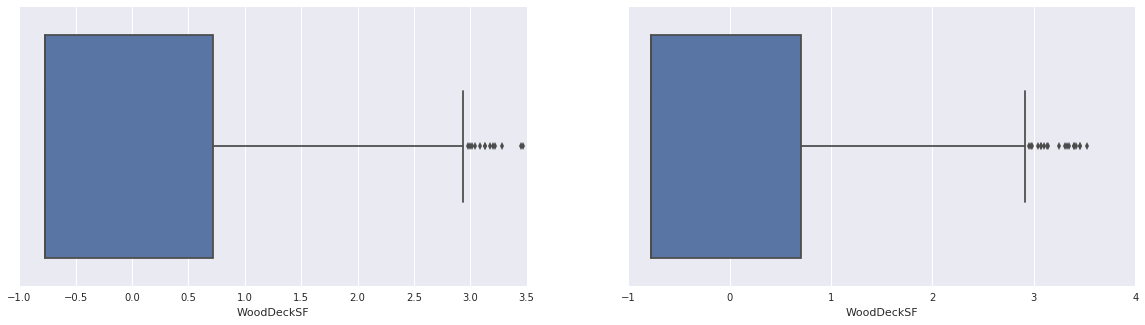

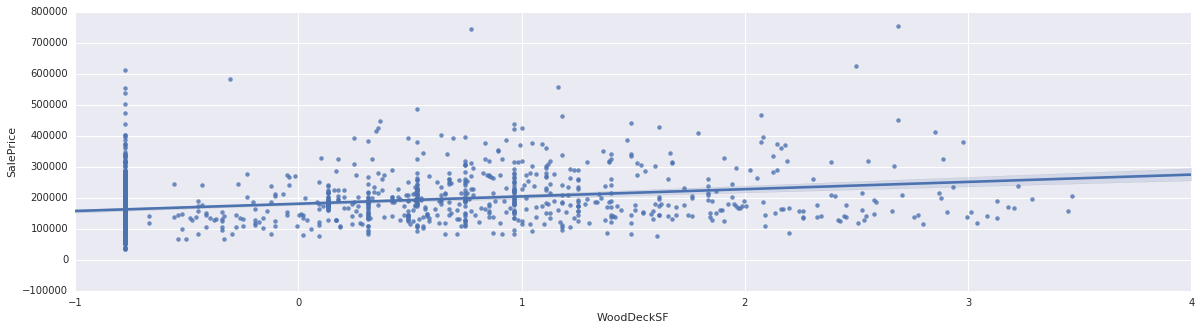

OpenPorchSF


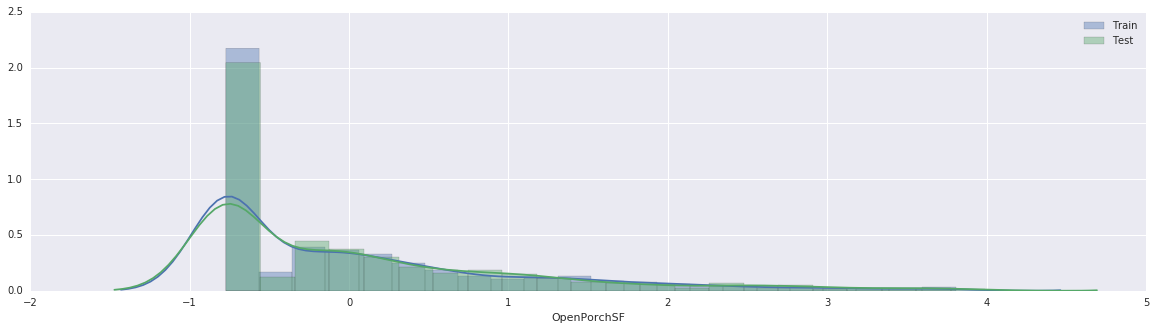

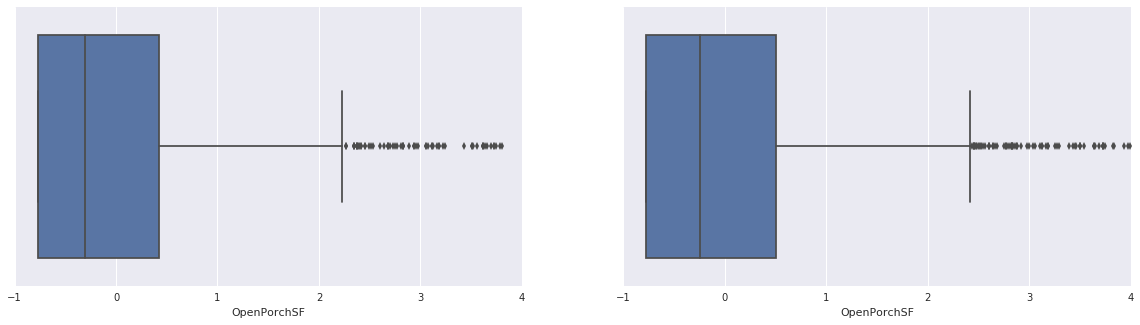

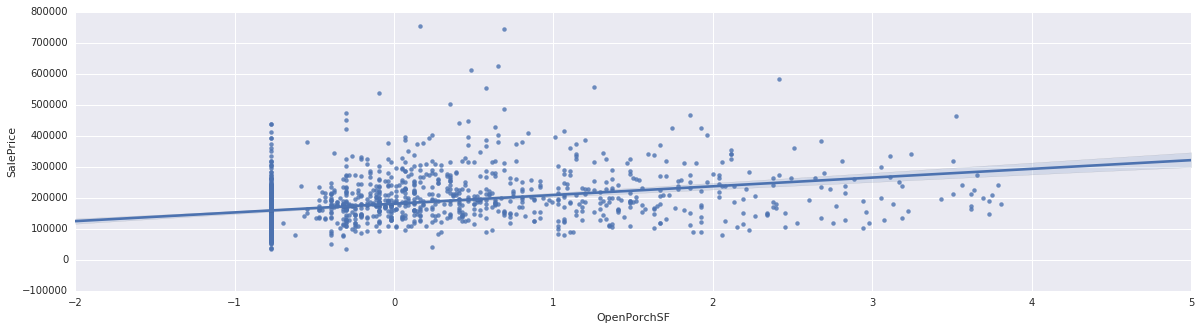

EnclosedPorch


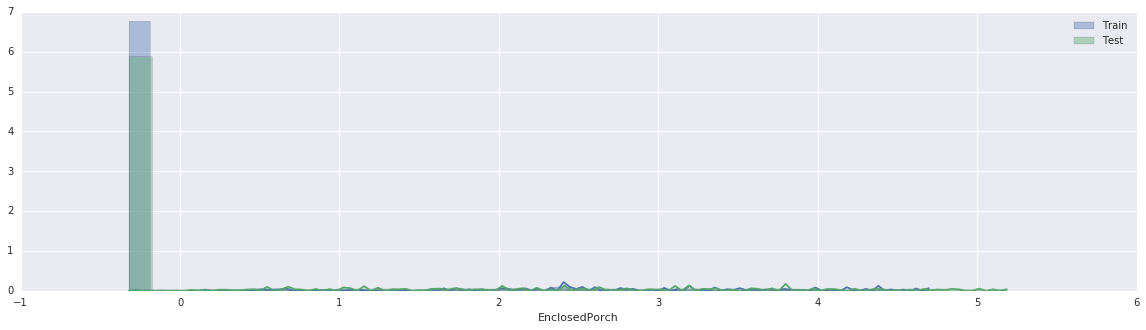

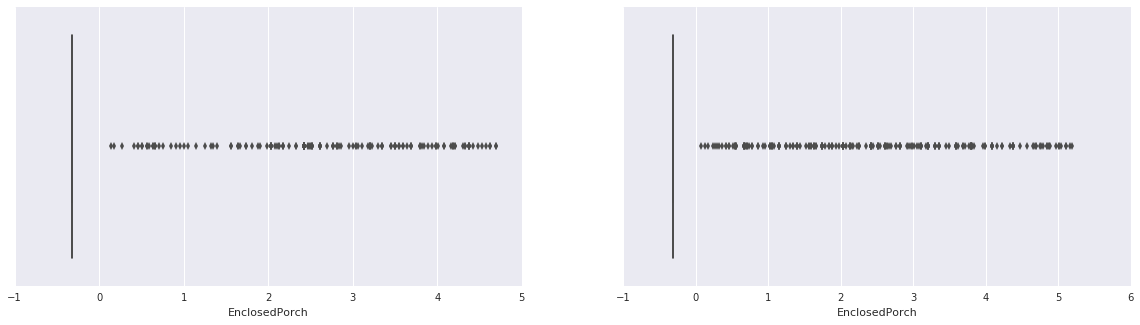

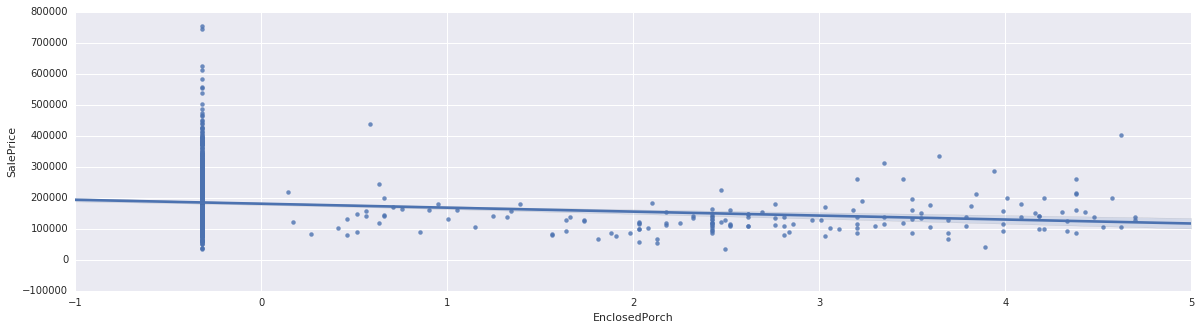

3SsnPorch


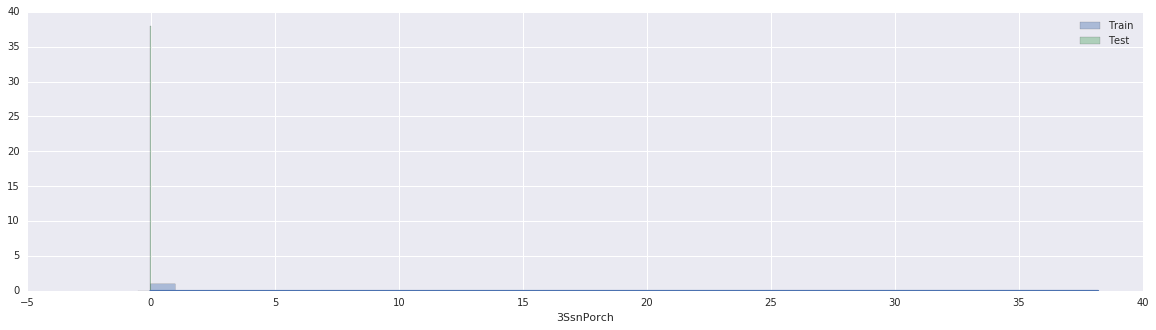

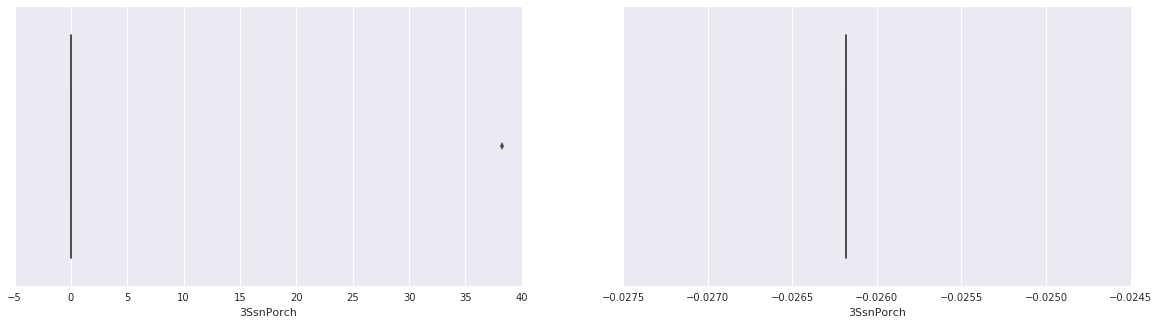

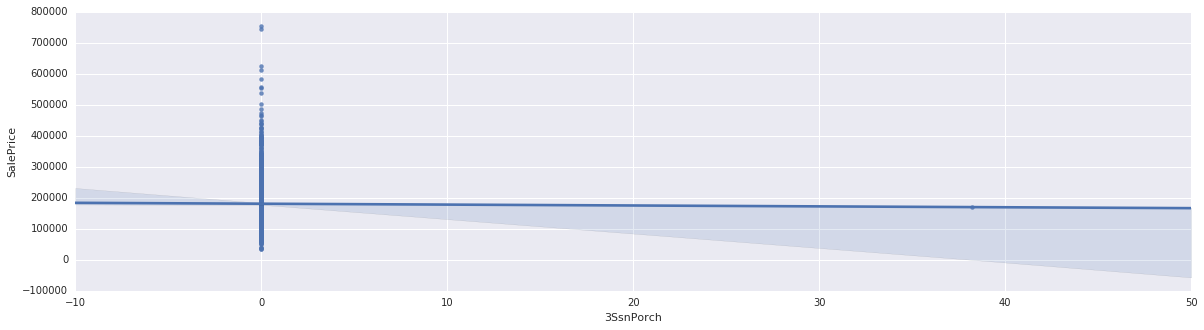

ScreenPorch


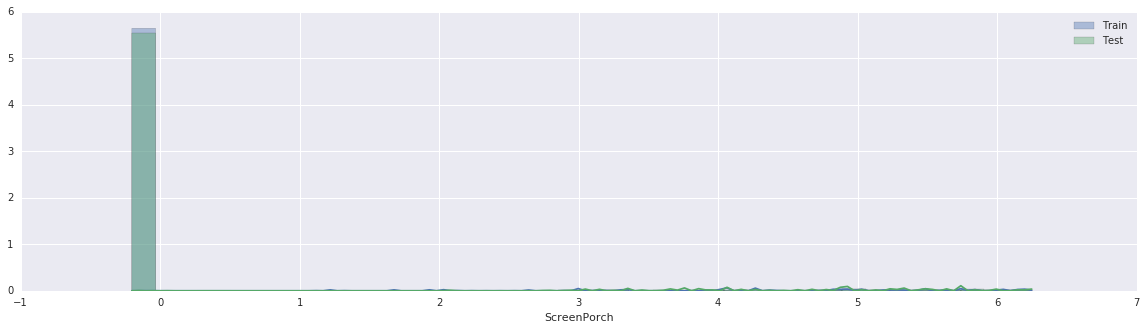

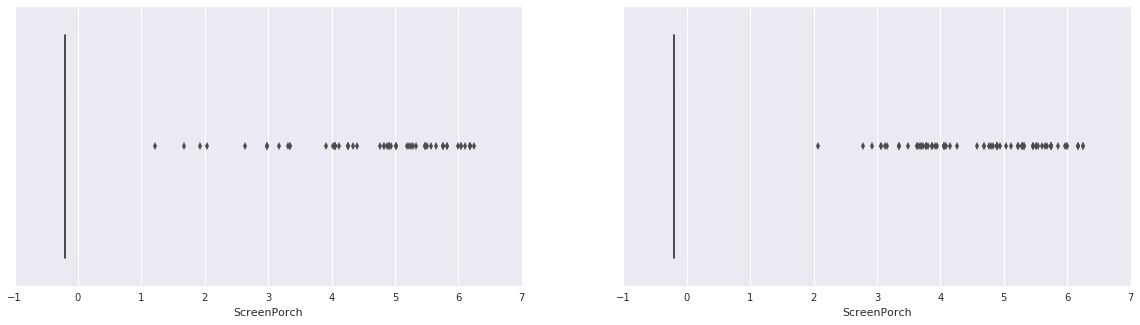

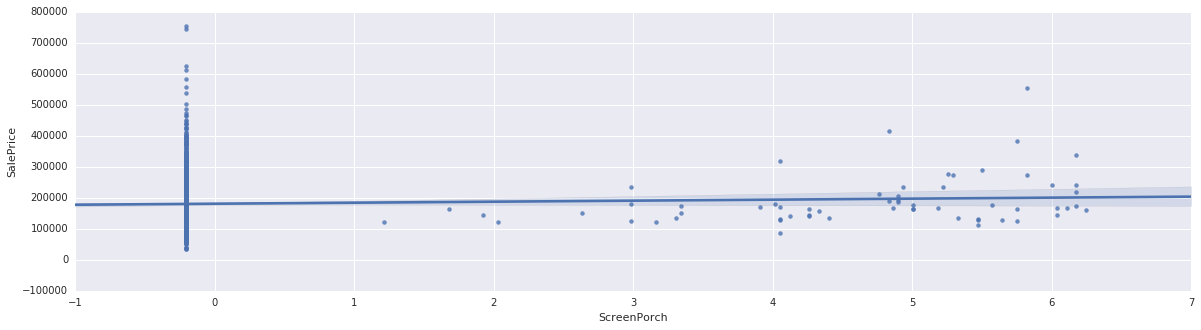

PoolArea


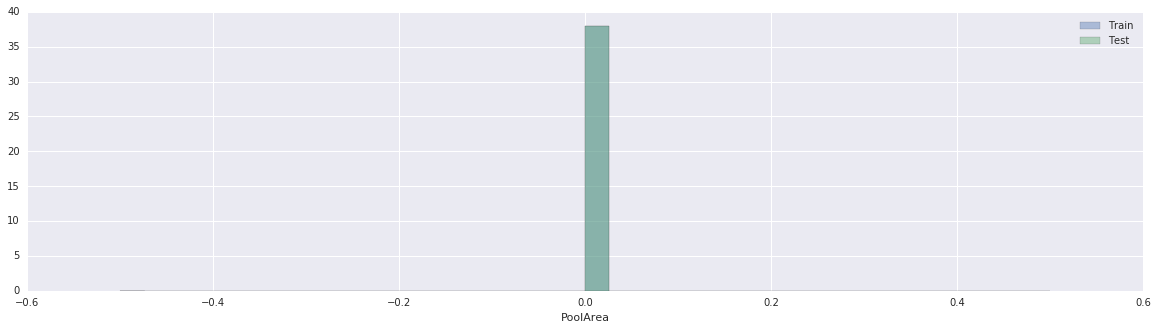

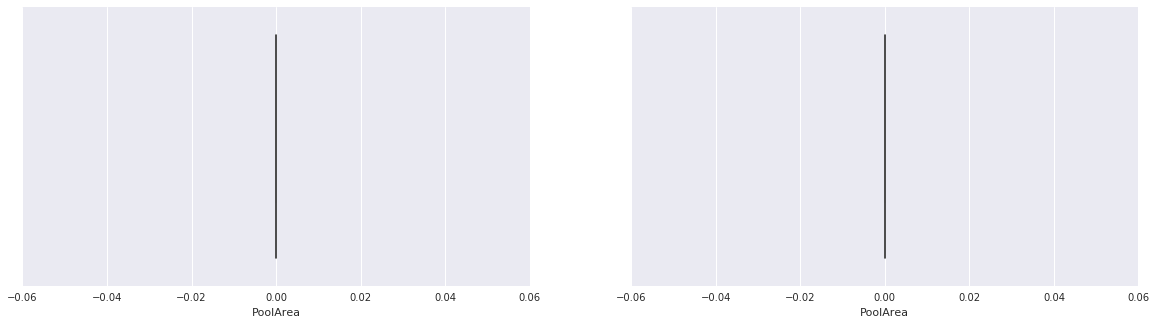

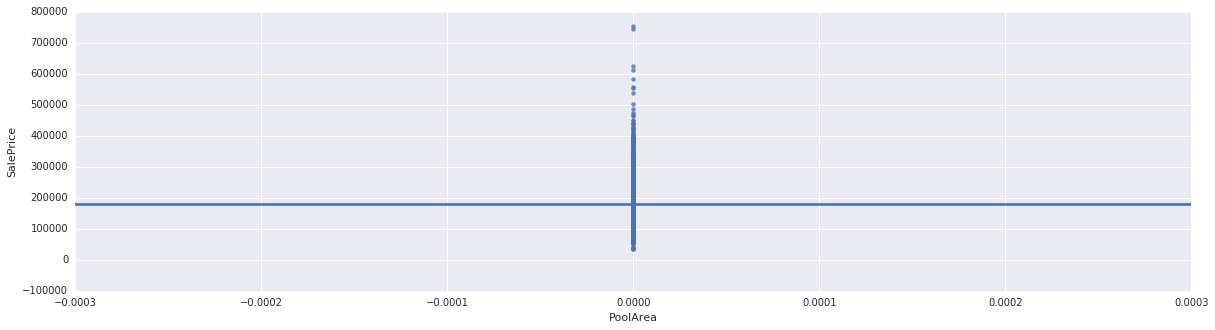

MiscVal


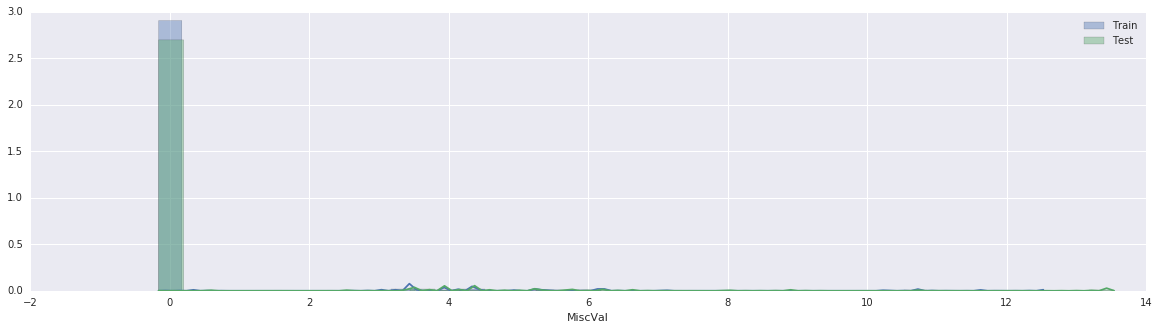

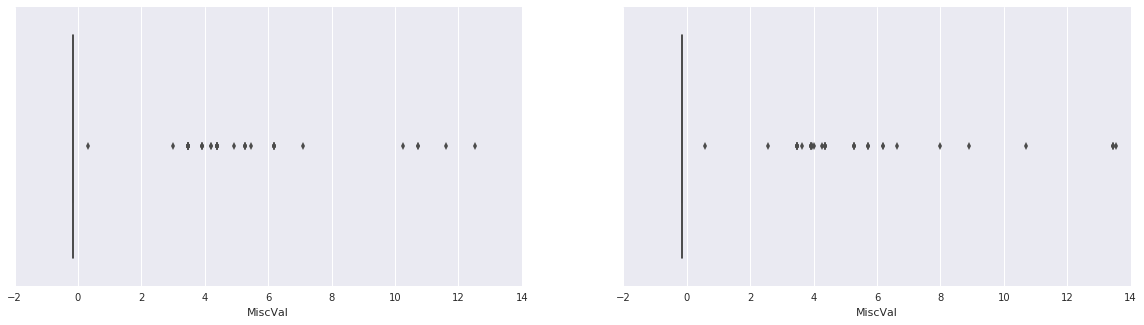

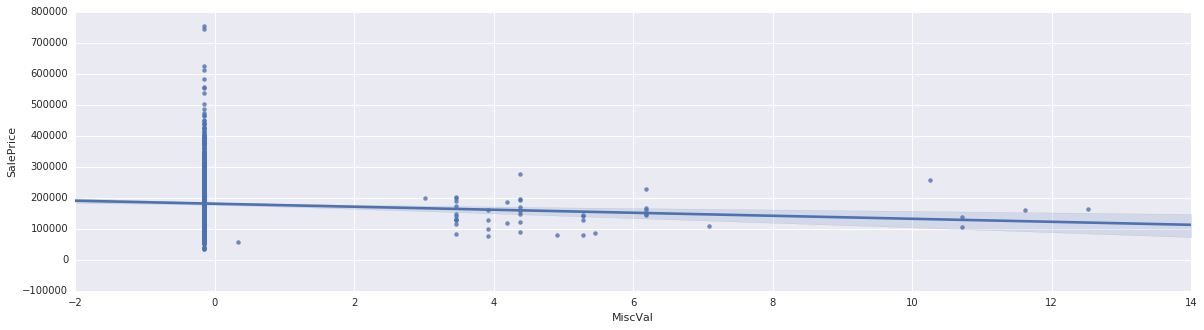

MoSold


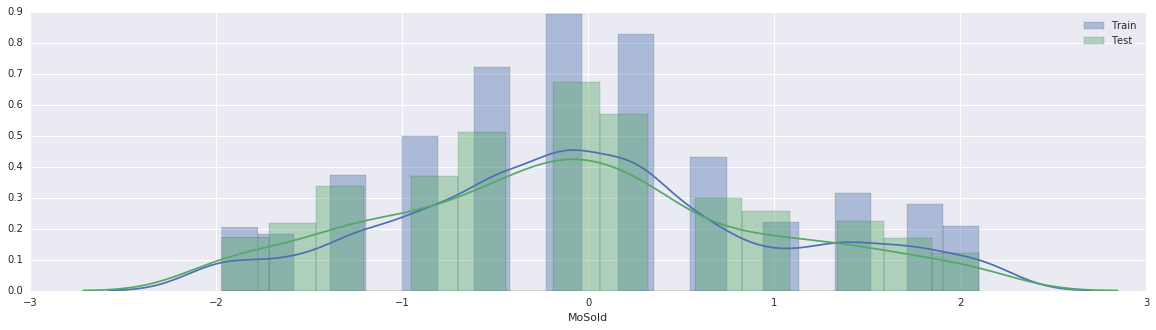

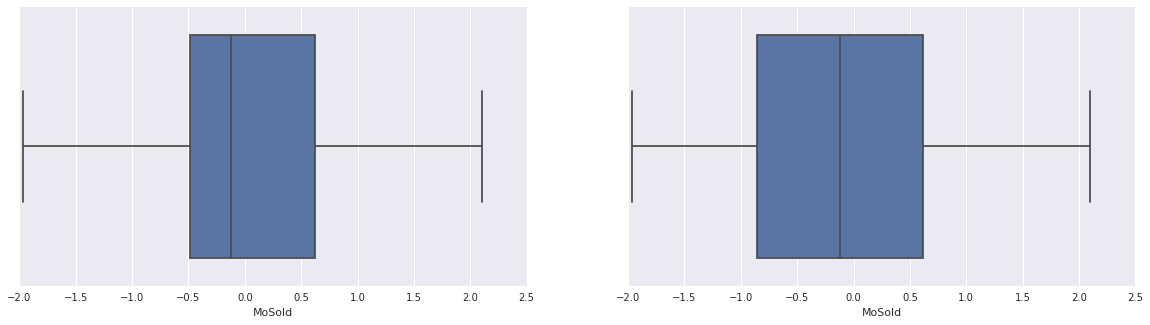

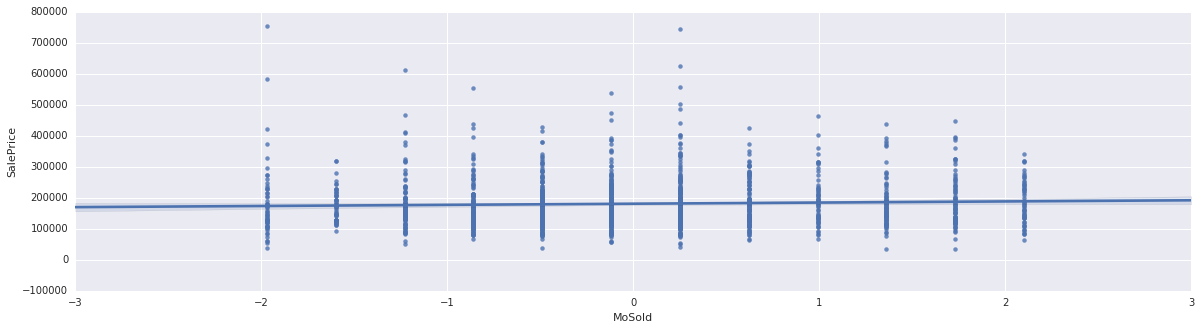

YrSold


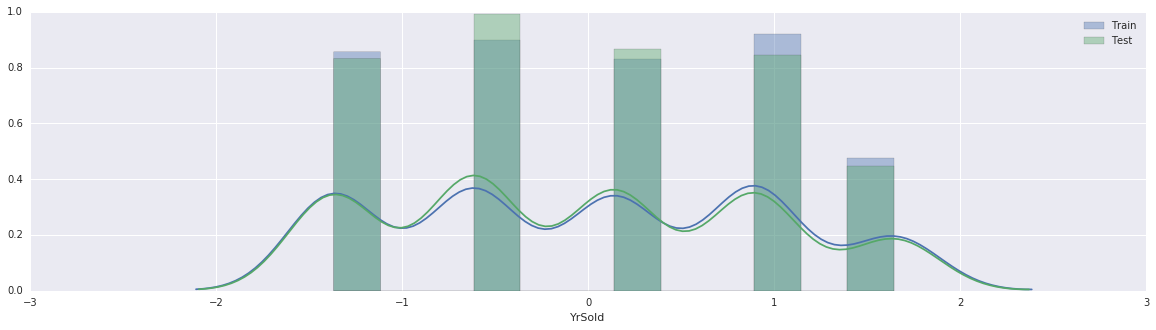

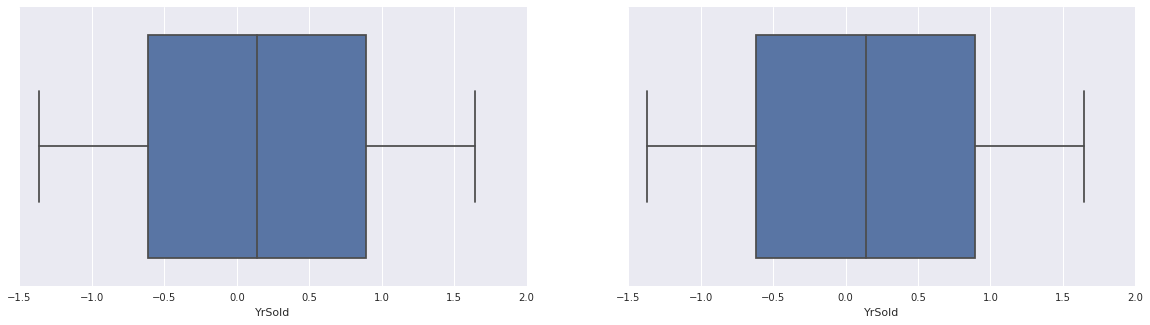

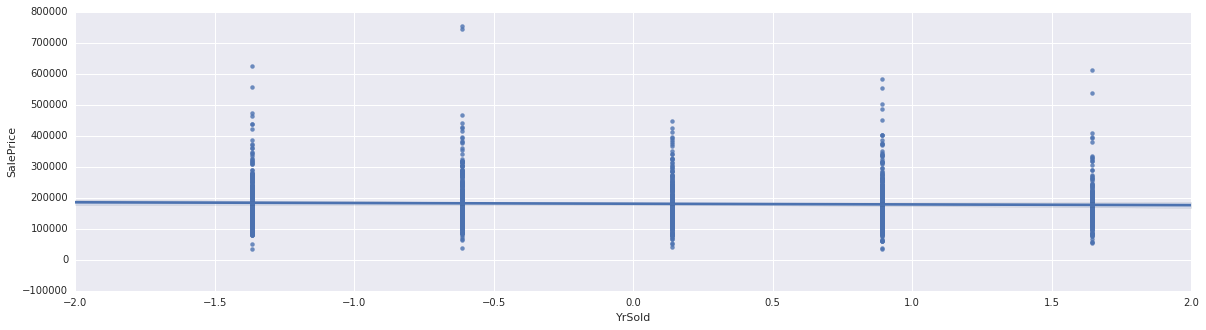

LotFrontage


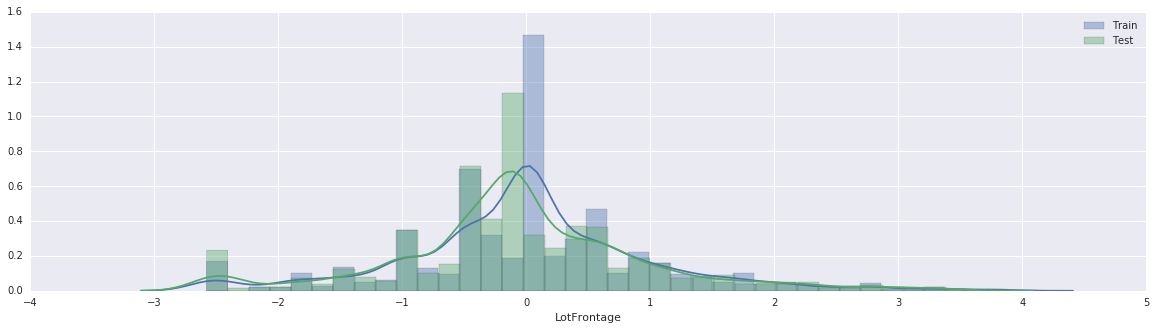

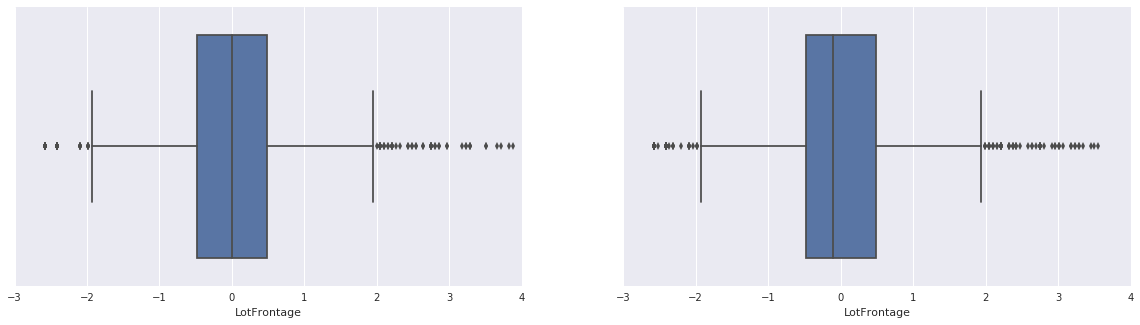

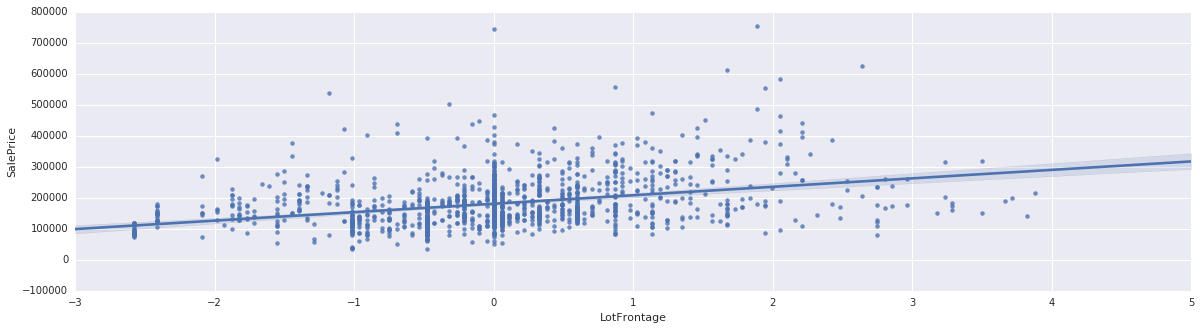

MasVnrArea


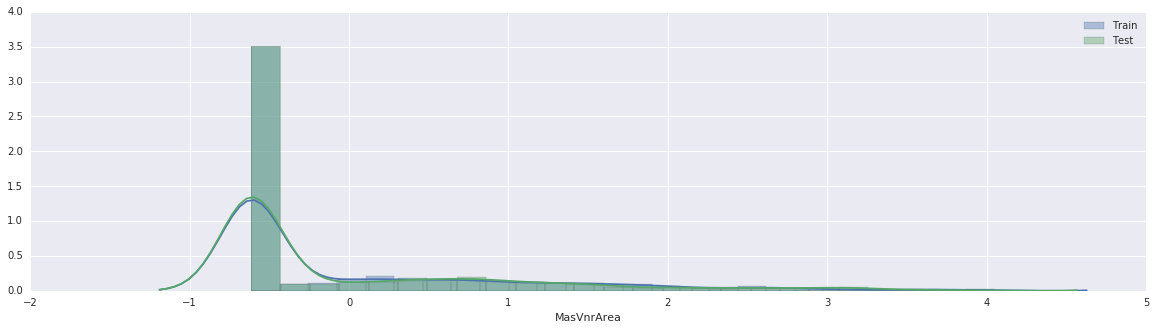

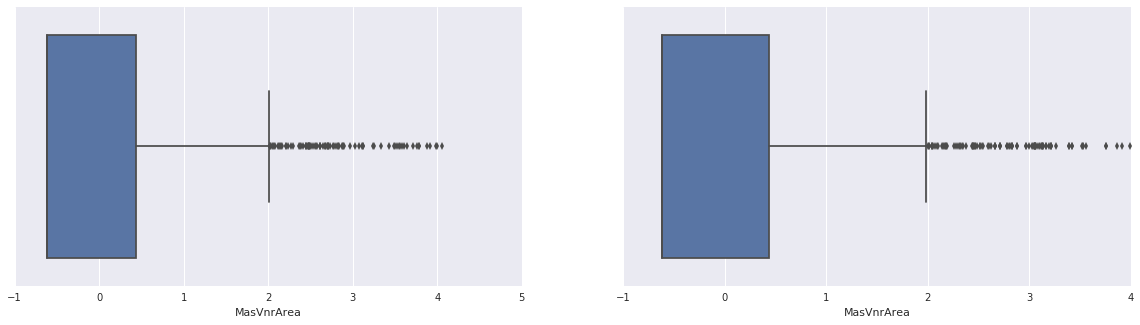

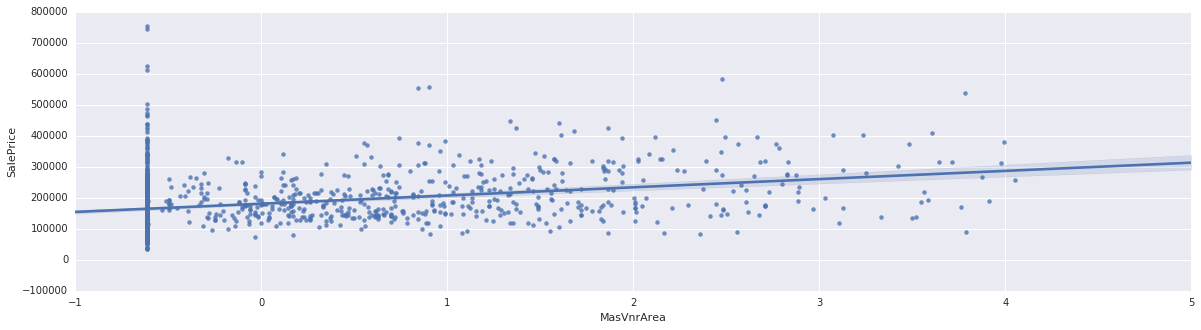

GarageYrBlt


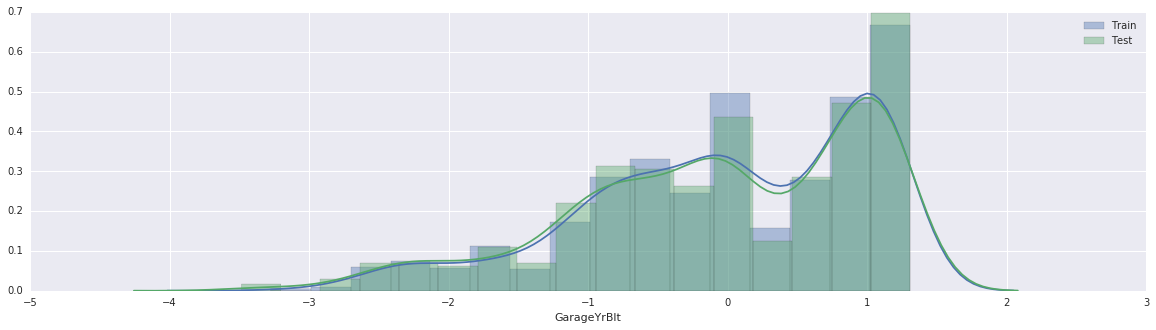

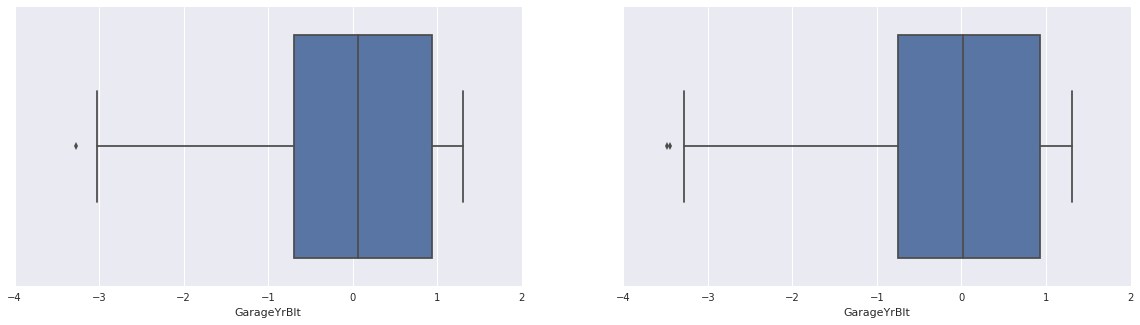

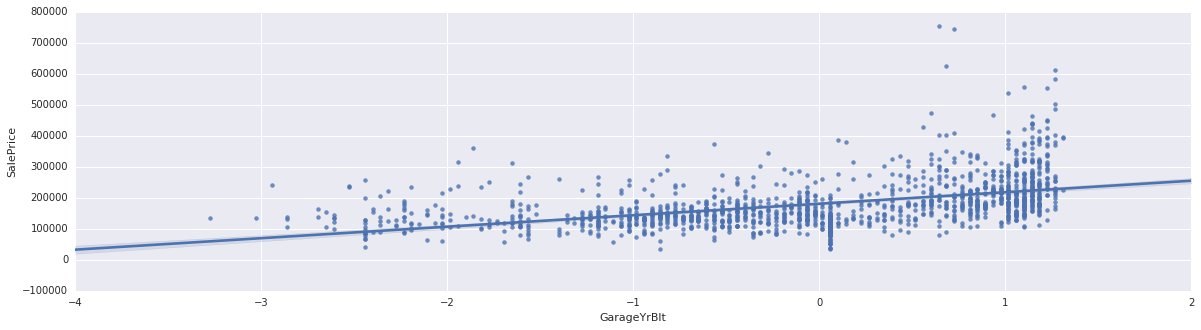

In [275]:
for column in continuous:
  print column
  process_continuous(column)

In [276]:
train_final = train_trans.copy()
train_final['Id'] = train.Id
train_final['SalePrice'] = np.log(train.SalePrice)

test_final = test_trans.copy()
test_final['Id'] = test.Id

In [277]:
train_final.head()

,LotArea,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,LotFrontage,MasVnrArea,GarageYrBlt,Id,SalePrice
0,-0.313194,1.050994,0.878668,0.640105,-0.256575,-0.959130,-0.473773,-0.831584,1.193392,-0.061094,0.468829,1.217782,0.0,0.789741,1.314904,0.195468,0.02618,0.994673,-0.962938,0.311725,0.382307,-0.776343,0.371663,-0.319264,-0.02618,-0.202155,0.0,-0.159453,-1.599111,0.138777,-0.209912,0.814853,1.017598,1,12.247694
1,-0.049290,0.156734,-0.429577,1.280861,-0.256575,-0.642207,0.555430,0.322607,-0.796451,-0.061094,-0.490381,-0.821165,0.0,0.789741,-0.760512,0.195468,0.02618,-0.303113,0.625638,0.311725,-0.044438,1.925720,-0.772409,-0.319264,-0.02618,-0.202155,0.0,-0.159453,-0.489110,-0.614439,0.597016,-0.613988,-0.107927,2,12.109011
2,0.329356,0.984752,0.830215,0.121847,-0.256575,-0.287442,-0.311534,-0.649643,1.221353,-0.061094,0.631552,1.217782,0.0,0.789741,1.314904,0.195468,0.02618,-0.303113,0.625638,0.311725,0.673271,-0.776343,0.015313,-0.319264,-0.02618,-0.202155,0.0,-0.159453,0.990891,0.138777,-0.048526,0.566992,0.934226,3,12.317167
3,-0.060764,-1.863632,-0.720298,-0.514197,-0.256575,-0.036742,-0.727271,-0.533086,0.965050,-0.061094,0.483817,1.217782,0.0,-1.026041,-0.760512,0.195468,0.02618,0.345780,0.625638,1.650307,0.838150,-0.776343,-0.115974,-0.319264,-0.02618,-0.202155,0.0,-0.159453,-1.599111,-1.367655,-0.478888,-0.613988,0.809167,4,11.849398
4,1.020097,0.951632,0.733308,0.519964,-0.256575,-0.154997,0.258837,-0.010004,1.657068,-0.061094,1.513682,1.217782,0.0,0.789741,1.314904,1.486796,0.02618,1.643566,0.625638,1.650307,1.778930,0.964583,0.803034,-0.319264,-0.02618,-0.202155,0.0,-0.159453,2.100892,0.138777,0.812197,1.937513,0.892540,5,12.429216


In [278]:
test_final.head()

,LotArea,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,LotFrontage,MasVnrArea,GarageYrBlt,Id
0,0.414723,-0.340077,-1.156380,0.079444,1.548299,-0.675318,-0.407863,-0.717871,-0.796451,-0.061094,-1.274021,-0.821165,0.0,-1.026041,-0.760512,-1.095860,0.02618,-0.952006,-0.962938,-1.026858,1.264895,0.493082,-0.772409,-0.319264,-0.02618,4.050671,0.0,-0.159453,-0.119110,1.64521,0.597016,-0.613988,-0.733219,1461
1,1.021704,-0.439440,-1.301740,1.151296,-0.256575,-0.353665,0.725274,0.513078,-0.796451,-0.061094,-0.346927,-0.821165,0.0,-1.026041,1.314904,0.195468,0.02618,-0.303113,-0.962938,-1.026858,-0.762147,2.787116,-0.097219,-0.319264,-0.02618,-0.202155,0.0,-0.159453,-0.119110,1.64521,0.650812,0.173332,-0.858277,1462
2,0.921420,0.852269,0.636400,0.840341,-0.256575,-0.989876,-0.291254,-0.626900,0.836898,-0.061094,0.295400,-0.821165,0.0,0.789741,1.314904,0.195468,0.02618,-0.303113,0.625638,0.311725,0.062248,1.145930,-0.134730,-0.319264,-0.02618,-0.202155,0.0,-0.159453,-1.229111,1.64521,0.274245,-0.613988,0.767481,1463
3,0.037454,0.885390,0.636400,0.395110,-0.256575,-0.547603,-0.296324,-0.632586,0.783308,-0.061094,0.241873,-0.821165,0.0,0.789741,1.314904,0.195468,0.02618,0.345780,0.625638,0.311725,0.004056,2.487894,-0.097219,-0.319264,-0.02618,-0.202155,0.0,-0.159453,-0.119110,1.64521,0.489426,-0.468188,0.809167,1464
4,-1.103761,0.686666,0.345679,-0.403478,-0.256575,1.091408,0.601060,0.373779,-0.796451,-0.061094,-0.451841,-0.821165,0.0,0.789741,-0.760512,-1.095860,0.02618,-0.952006,-0.962938,0.311725,0.178633,-0.776343,0.765524,-0.319264,-0.02618,4.901236,0.0,-0.159453,-1.969111,1.64521,-1.393407,-0.613988,0.559051,1465


In [279]:
train_final.to_csv('train_inc.csv', index=False)
test_final.to_csv('test_inc.csv', index=False)